
# YOLO11 Trash Segmentation Pipeline
## Complete Computer Vision Pipeline for Waste Detection and Segmentation

This notebook implements a complete trash segmentation pipeline using YOLO11. The goal is to train a model capable of detecting and segmenting trash objects in images, providing both bounding boxes and precise segmentation masks.


## 🌊 Project Overview

This project implements a marine waste segmentation and detection system using the latest YOLO11 segmentation architecture. The pipeline includes:

- Dataset preparation and preprocessing for marine debris detection
- Model training with YOLO11 segmentation for precise waste localization
- Comprehensive evaluation and visualization of detection performance
- Error analysis and marine debris category performance metrics
- Production-ready inference capabilities for ocean cleanup systems

**Key Features:**
- Focus on critical marine debris categories: plastic bottles, bags, fishing nets, metal cans, glass
- YOLO11 segmentation architecture for precise debris boundary detection
- Automated data preprocessing with marine image validation
- Comprehensive evaluation metrics (precision, recall, mAP, F1-score)
- Visual analysis tools for training monitoring
- Production-ready model export for marine cleanup robotics

**Target Applications:**
- Autonomous underwater cleanup vehicles
- Marine environmental monitoring systems
- Ocean conservation research platforms
- Coastal pollution assessment tools
- Smart marine debris detection systems

**Dataset Categories:**
- **Plastic Bottles**: Single-use beverage containers
- **Plastic Bags**: Flexible plastic packaging materials
- **Fishing Nets**: Abandoned fishing equipment
- **Metal Cans**: Aluminum and steel containers
- **Glass Objects**: Bottles and container fragments

**Technical Stack:**
- YOLO11 segmentation for state-of-the-art marine debris detection
- PyTorch backend for deep learning
- Automated train/validation splitting
- Real-time training metrics visualization
- GPU acceleration support

In [1]:
# prompt: connect to google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install machine learning and image processing libraries

In [2]:
!pip install datasets opencv-python scikit-learn pillow kaggle

In [3]:
!pip install --upgrade ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 25.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

### 🔧 Initial Setup

Imports all required libraries and sets global parameters such as project paths, plot styles, and class mapping variables. This prepares the environment for training and evaluating the YOLO model.

In [36]:
import os
import kagglehub
from ultralytics import YOLO
import shutil
import yaml
from pathlib import Path
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import json
from datetime import datetime
import torch
from tqdm import tqdm
import subprocess

# Configure matplotlib for displaying plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Global variables for the project
PROJECT_DIR = "yolo11_trash"
DATASET_DIR = os.path.join(PROJECT_DIR, "dataset")
RESULTS_DIR = os.path.join(PROJECT_DIR, "results")
QUICK_TRAINING = False  # Set to False for full training

# Variables to be preserved across steps
class_mapping = {}
class_names = []
train_annotations = {}
dataset_info = {}

## Step 1: Initial Setup

**Purpose:** Establishes the complete directory structure and initializes the working environment for the marine waste segmentation project.

**What it does:**
- Creates main project directory structure for organized data management
- Sets up dataset subdirectories for images and segmentation labels
- Creates separate train/validation splits directories for model training
- Initializes results directory for storing training outputs and model artifacts
- Ensures proper folder hierarchy for YOLO11 segmentation pipeline

**Directory Structure Created:**
```
marine_waste_segmentation/
├── dataset/
│   ├── images/
│   │   ├── train/
│   │   └── val/
│   └── labels/
│       ├── train/
│       └── val/
└── results/
```

**Key Benefits:**
- Organized data structure compatible with YOLO11 format requirements
- Separation of training and validation data for proper model evaluation
- Centralized results storage for easy access to training artifacts
- Scalable architecture for handling large marine debris datasets

In [57]:
# ============================================================================
# STEP 1: INITIAL SETUP
# ============================================================================
def initial_setup():
    """Create directory structure for trash segmentation project"""
    dirs_to_create = [
        DATASET_DIR,
        os.path.join(DATASET_DIR, "images", "train"),
        os.path.join(DATASET_DIR, "images", "val"),
        os.path.join(DATASET_DIR, "labels", "train"),
        os.path.join(DATASET_DIR, "labels", "val"),
        RESULTS_DIR
    ]

    for dir_path in dirs_to_create:
        os.makedirs(dir_path, exist_ok=True)

    print(f"📁 Directories created in: {PROJECT_DIR}")
    print("✅ Initial setup completed for trash segmentation pipeline\n")
    return True

## Step 2: Dataset Download from Kaggle

**Purpose:** Downloads and extracts the trashcan segmentation dataset from Kaggle competition for training the YOLO11 segmentation model.

**What it does:**
- Sets up and validates Kaggle API credentials
- Downloads the `trashcan-segmentation-public` competition dataset
- Extracts the dataset to the project directory
- Implements fallback methods for robust downloading
- Organizes raw dataset for preprocessing pipeline

**Functions:**

### `setup_kaggle_credentials()`
- Checks for existing Kaggle API credentials (`kaggle.json`)
- Sets proper file permissions for security
- Provides step-by-step setup instructions if credentials are missing
- Validates credential configuration

### `download_dataset()`
- Downloads competition dataset using Kaggle API
- Implements dual download methods:
  - **Primary**: Direct Python API call
  - **Fallback**: Command-line interface method
- Extracts ZIP files automatically
- Cleans up temporary files to save storage space

**Directory Structure After Download:**
```
yolo11_trash/
├── raw_dataset/
│   └── trashcan-segmentation-public/
│       ├── train/
│       ├── test/
│       └── annotations/
└── dataset/
    └── [organized structure from Step 1]
```


In [58]:
# ============================================================================
# STEP 2: DOWNLOAD DATASET FROM KAGGLE
# ============================================================================
import os
import subprocess
import zipfile
import shutil
from pathlib import Path
import json

def setup_kaggle_credentials():
    """Setup Kaggle credentials"""
    print("🔑 Setting up Kaggle credentials...")

    # Check if kaggle.json exists
    kaggle_dir = Path.home() / '.kaggle'
    kaggle_json = kaggle_dir / 'kaggle.json'


    if not kaggle_json.exists():
        print("❌ kaggle.json not found")
        print("Please follow these steps:")
        print("1. Go to https://www.kaggle.com/account")
        print("2. Click 'Create New API Token'")
        print("3. Download kaggle.json file")
        print("4. Run the following commands:")
        print(f"   mkdir -p {kaggle_dir}")
        print(f"   mv kaggle.json {kaggle_json}")
        print(f"   chmod 600 {kaggle_json}")
        return False

    # Set permissions
    kaggle_json.chmod(0o600)
    print("✅ Kaggle credentials configured")
    return True

def download_dataset():
    """Download trashcan-segmentation-public dataset from Kaggle - FIXED VERSION"""
    try:
        print("📥 Downloading trashcan-segmentation-public dataset from Kaggle...")

        # Setup Kaggle credentials first
        if not setup_kaggle_credentials():
            return None

        # Competition name
        competition_name = "trashcan-segmentation-public"

        # Create download directory
        download_dir = os.path.join("yolo11_trash", "raw_dataset")
        os.makedirs(download_dir, exist_ok=True)

        # Try to download using kaggle API directly
        try:
            import kaggle
            kaggle.api.authenticate()

            # Download competition files
            print(f"🔄 Downloading {competition_name}...")
            kaggle.api.competition_download_files(competition_name, path=download_dir)

            # Extract zip file
            zip_path = os.path.join(download_dir, f"{competition_name}.zip")
            if os.path.exists(zip_path):
                print("📂 Extracting dataset...")
                with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                    zip_ref.extractall(download_dir)

                # Remove zip file to save space
                os.remove(zip_path)
                print("✅ Dataset downloaded and extracted successfully")

                download_dir = os.path.join(download_dir, f"trashcan-segmentation-public")
                return download_dir
            else:
                print("❌ Zip file not found after download")
                return None

        except Exception as api_error:
            print(f"❌ Kaggle API error: {api_error}")

            # Fallback to CLI method
            print("🔄 Trying CLI method...")
            download_command = f"kaggle competitions download -c {competition_name}"

            result = subprocess.run(download_command.split(),
                                  cwd=download_dir,
                                  capture_output=True,
                                  text=True)

            if result.returncode == 0:
                print("✅ Dataset downloaded successfully via CLI")

                # Extract zip file
                zip_path = os.path.join(download_dir, f"{competition_name}.zip")
                if os.path.exists(zip_path):
                    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                        zip_ref.extractall(download_dir)
                    os.remove(zip_path)
                    print("📂 Dataset extracted successfully")

                download_dir = os.path.join(download_dir, f"trashcan-segmentation-public")
                return download_dir
            else:
                print(f"❌ CLI download error: {result.stderr}")
                return None

    except Exception as e:
        print(f"❌ Error downloading dataset: {e}")
        print("💡 Make sure you have kaggle installed: pip install kaggle")
        print("💡 Setup instructions: https://github.com/Kaggle/kaggle-api#api-credentials")
        return None

## Step 3: Analyze Kaggle Dataset Structure

**Purpose:** Analyzes and validates the downloaded trashcan segmentation dataset structure to understand the data format and prepare for preprocessing.

**What it does:**
- Loads and parses the COCO-format JSON annotation file
- Extracts dataset metadata and structural information
- Analyzes class categories and creates mapping dictionaries
- Validates segmentation annotation availability
- Provides comprehensive dataset statistics overview

**Key Operations:**

### Dataset Loading
- Locates and loads `train.json` annotation file
- Validates file existence and accessibility
- Parses JSON structure following COCO annotation format

### Structure Analysis
- **Info Section**: Dataset metadata and description
- **Licenses**: Licensing information for the dataset
- **Images**: Total count of training images available
- **Annotations**: Total segmentation annotations count
- **Categories**: Waste classification categories

### Class Mapping Creation
- Extracts class names from categories section
- Creates ID-to-index mapping for YOLO format conversion
- Stores class information in global variables for pipeline use

### Segmentation Validation
- Counts annotations containing segmentation polygons
- Validates data integrity for segmentation training
- Reports segmentation coverage statistics

**Output Information:**
```
📊 Dataset Structure Analysis:
   - Info: {dataset metadata}
   - Licenses: [number of licenses]
   - Images: [total image count]
   - Annotations: [total annotation count]
   - Categories: [number of classes]
   - Class names: [list of waste categories]
   - Annotations with segmentation: [segmentation count]
```

**Global Variables Updated:**
- `train_annotations`: Complete COCO annotation data
- `dataset_info`: Dataset metadata information
- `class_names`: List of waste category names
- `class_mapping`: Category ID to index mapping

**Data Validation:**
- Verifies JSON file structure integrity
- Confirms presence of required COCO format fields
- Validates segmentation annotation availability
- Reports any structural inconsistencies

In [59]:
# ============================================================================
# STEP 3: ANALYZE KAGGLE DATASET STRUCTURE
# ============================================================================
def analyze_dataset_structure(dataset_path):
    """Analyze the Kaggle trashcan segmentation dataset structure"""
    global train_annotations, dataset_info, class_names, class_mapping

    print("🔍 Analyzing Kaggle dataset structure...")

    # Look for JSON files
    train_json_path = os.path.join(dataset_path, "train.json")

    if not os.path.exists(train_json_path):
        print(f"❌ Training JSON not found at: {train_json_path}")
        return False

    # Load training annotations
    with open(train_json_path, 'r') as f:
        train_annotations = json.load(f)

    print("📊 Dataset Structure Analysis:")
    print(f"   - Info: {train_annotations.get('info', {})}")
    print(f"   - Licenses: {len(train_annotations.get('licenses', []))}")
    print(f"   - Images: {len(train_annotations.get('images', []))}")
    print(f"   - Annotations: {len(train_annotations.get('annotations', []))}")
    print(f"   - Categories: {len(train_annotations.get('categories', []))}")

    # Extract categories and create class mapping
    categories = train_annotations.get('categories', [])
    class_names = [cat['name'] for cat in categories]
    class_mapping = {cat['id']: idx for idx, cat in enumerate(categories)}

    print(f"   - Class names: {class_names}")

    # Analyze segmentation data
    annotations = train_annotations.get('annotations', [])
    segmentation_count = sum(1 for ann in annotations if 'segmentation' in ann)

    print(f"   - Annotations with segmentation: {segmentation_count}")

    # Store dataset info
    dataset_info = train_annotations.get('info', {})

    print("✅ Dataset structure analysis completed\n")
    return True

## Step 4: Convert Annotations to YOLO Format

**Purpose:** Converts COCO-format annotations from Kaggle dataset to YOLO11 segmentation format and organizes data for training.

**What it does:**
- Converts COCO polygon annotations to YOLO segmentation format
- Copies and organizes images into proper directory structure
- Normalizes polygon coordinates to relative values (0-1)
- Implements binary segmentation approach (object vs background)
- Splits dataset into training and validation sets (80-20)

**Functions:**

### `convert_to_yolo_format(dataset_path)`

**Annotation Processing:**
- Groups annotations by image ID for efficient processing
- Extracts segmentation polygons from COCO format
- Converts absolute pixel coordinates to normalized coordinates
- Handles multiple segmentation polygons per object
- Validates polygon integrity (minimum 3 points)

**Binary Segmentation Approach:**
- Uses single class (class 0) for all waste objects
- Simplifies detection to object vs background classification
- Reduces complexity while maintaining segmentation precision

**File Organization:**
- Copies source images to training directory
- Creates corresponding label files with `.txt` extension
- Maintains filename consistency between images and labels
- Processes images with progress tracking using tqdm

**Coordinate Normalization:**
```python
x_normalized = x_pixel / image_width
y_normalized = y_pixel / image_height
```

**YOLO Format Output:**
```
class_id x1 y1 x2 y2 x3 y3 ... xn yn
```

### `split_train_val()`

**Dataset Splitting:**
- Implements 80-20 train/validation split
- Uses random seed (42) for reproducible splits
- Moves validation files from train to val directories
- Maintains image-label pair consistency

**File Operations:**
- Identifies all image files in training directory
- Moves corresponding label files automatically
- Provides detailed statistics on split results
- Handles missing files gracefully

**Validation Metrics:**
```
📊 Dataset split completed:
   - Training images: [count]
   - Validation images: [count]
   - Images moved to val: [count]
   - Labels moved to val: [count]
```

**Directory Structure After Conversion:**
```
dataset/
├── images/
│   ├── train/          # 80% of images
│   │   ├── image1.jpg
│   │   └── image2.jpg
│   └── val/            # 20% of images
│       ├── image3.jpg
│       └── image4.jpg
└── labels/
    ├── train/          # Corresponding training labels
    │   ├── image1.txt
    │   └── image2.txt
    └── val/            # Corresponding validation labels
        ├── image3.txt
        └── image4.txt
```

In [60]:
# ============================================================================
# STEP 4: CONVERT ANNOTATIONS TO YOLO FORMAT
# ============================================================================
def convert_to_yolo_format(dataset_path):
    """Convert Kaggle dataset annotations to YOLO segmentation format"""
    global train_annotations, class_mapping

    print("🔄 Converting annotations to YOLO segmentation format...")

    # Get images and annotations
    images = {img['id']: img for img in train_annotations['images']}
    annotations = train_annotations['annotations']

    # Find train images directory
    train_images_source = os.path.join(dataset_path, "train", "train")

    print(train_images_source)
    print(f"📂 Looking for images in: {train_images_source}")

    if not os.path.exists(train_images_source):
        print("❌ Train images directory not found")
        return False

    # For binary segmentation (object vs background), use single class
    print("📋 Binary segmentation task - using single class (class 0)")
    class_mapping = {}  # Not needed for binary segmentation

    # Process each image
    processed_images = 0
    created_labels = 0

    # Group annotations by image
    annotations_by_image = {}
    for ann in annotations:
        img_id = ann['image_id']
        if img_id not in annotations_by_image:
            annotations_by_image[img_id] = []
        annotations_by_image[img_id].append(ann)

    for img_id, img_info in tqdm(images.items(), desc="Converting images"):
        img_filename = img_info['file_name']
        img_width = img_info['width']
        img_height = img_info['height']

        # Copy image file
        source_img_path = os.path.join(train_images_source, img_filename)
        dest_img_path = os.path.join(DATASET_DIR, "images", "train", img_filename)

        if os.path.exists(source_img_path):
            shutil.copy2(source_img_path, dest_img_path)
            processed_images += 1

            # Create label file
            label_filename = os.path.splitext(img_filename)[0] + '.txt'
            label_path = os.path.join(DATASET_DIR, "labels", "train", label_filename)

            # Process annotations for this image
            img_annotations = annotations_by_image.get(img_id, [])

            with open(label_path, 'w') as f:
                for ann in img_annotations:
                    if 'segmentation' in ann and ann['segmentation']:
                        # For binary segmentation, always use class 0
                        class_idx = 0

                        # Process segmentation polygons
                        segmentation = ann['segmentation']

                        # Handle different segmentation formats
                        if isinstance(segmentation, list):
                            for seg in segmentation:
                                if isinstance(seg, list) and len(seg) >= 6:  # At least 3 points (x, y pairs)
                                    # Normalize coordinates
                                    normalized_coords = []
                                    for i in range(0, len(seg), 2):
                                        if i + 1 < len(seg):
                                            # Ensure coordinates are within image bounds
                                            x = max(0.0, min(1.0, float(seg[i]) / img_width))
                                            y = max(0.0, min(1.0, float(seg[i + 1]) / img_height))
                                            normalized_coords.extend([x, y])

                                    if len(normalized_coords) >= 6:  # At least 3 points
                                        # Write YOLO segmentation format
                                        line = f"{class_idx} " + " ".join(f"{coord:.6f}" for coord in normalized_coords)
                                        f.write(line + "\n")

            created_labels += 1
        else:
            print(f"⚠️ Image not found: {source_img_path}")

    print(f"📋 Conversion completed:")
    print(f"   - Images processed: {processed_images}")
    print(f"   - Labels created: {created_labels}")
    print(f"   - Single class segmentation (class 0)")

    # Split into train/val
    split_train_val()

    print("✅ YOLO format conversion completed\n")
    return True

def split_train_val():
    """Split dataset into train and validation sets"""
    train_images_dir = os.path.join(DATASET_DIR, "images", "train")
    train_labels_dir = os.path.join(DATASET_DIR, "labels", "train")

    val_images_dir = os.path.join(DATASET_DIR, "images", "val")
    val_labels_dir = os.path.join(DATASET_DIR, "labels", "val")

    # Get all image files
    image_files = [f for f in os.listdir(train_images_dir)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if len(image_files) == 0:
        print("⚠️ No image files found for train/val split")
        return

    # Split 80-20
    train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

    print(f"📊 Splitting {len(image_files)} images into train/val...")

    # Move validation files
    moved_images = 0
    moved_labels = 0

    for img_file in val_files:
        # Move image
        src_img = os.path.join(train_images_dir, img_file)
        dst_img = os.path.join(val_images_dir, img_file)
        if os.path.exists(src_img):
            shutil.move(src_img, dst_img)
            moved_images += 1

        # Move corresponding label
        label_file = os.path.splitext(img_file)[0] + '.txt'
        src_label = os.path.join(train_labels_dir, label_file)
        dst_label = os.path.join(val_labels_dir, label_file)
        if os.path.exists(src_label):
            shutil.move(src_label, dst_label)
            moved_labels += 1

    print(f"📊 Dataset split completed:")
    print(f"   - Training images: {len(train_files)}")
    print(f"   - Validation images: {len(val_files)}")
    print(f"   - Images moved to val: {moved_images}")
    print(f"   - Labels moved to val: {moved_labels}")

## Step 5: Create YAML Configuration

**Purpose:** Creates a YAML configuration file that defines the dataset structure and parameters for YOLO11 segmentation training.

**What it does:**
- Generates YOLO-compatible YAML configuration file
- Defines dataset paths and structure for training
- Configures binary segmentation parameters (single class)
- Validates dataset integrity before training
- Verifies label file format and content

**Configuration Parameters:**

### YAML Structure
```yaml
path: /absolute/path/to/dataset
train: images/train
val: images/val  
nc: 1                    # Number of classes (binary segmentation)
names: ['object']        # Class names list
```

### Key Configuration Elements:
- **Path**: Absolute path to dataset root directory
- **Train**: Relative path to training images
- **Val**: Relative path to validation images  
- **NC**: Number of classes (1 for binary segmentation)
- **Names**: List of class names for the model

**Dataset Validation:**

### File Counting
- Counts training images (PNG, JPG, JPEG formats)
- Counts training label files (TXT format)
- Counts validation images and labels
- Reports dataset statistics for verification

### Label File Verification
- Samples first 3 label files for format validation
- Checks minimum coordinate requirements (class + 3 coordinate pairs)
- Validates YOLO segmentation format structure
- Reports any formatting issues or empty files

**Validation Output:**
```
📊 Dataset verification:
   - Train images: [count]
   - Train labels: [count]
   - Val images: [count]
   - Val labels: [count]

🔍 Verifying label files...
   ✅ label1.txt: class=0, coordinates=12
   ✅ label2.txt: class=0, coordinates=8
   ❌ label3.txt: Invalid format - 3 parts
```

**Error Handling:**
- **No Training Data**: Stops execution if no training images/labels found
- **No Validation Data**: Issues warning but continues (training can proceed)
- **Invalid Labels**: Reports formatting issues in label files
- **Missing Directories**: Handles non-existent directory paths gracefully

**Binary Segmentation Approach:**
- Uses single class (class 0) for all objects
- Simplifies multi-class problem to object vs background
- Reduces training complexity while maintaining segmentation accuracy
- Suitable for general waste detection applications

**File Output:**
- Creates `trash_segment_config.yaml` in project root
- Uses absolute paths for cross-platform compatibility
- Standard YAML format compatible with YOLO11
- Ready for immediate use in training pipeline

In [61]:
# ============================================================================
# STEP 5: CREATE YAML CONFIGURATION
# ============================================================================
def create_yaml_config():
    """Create YAML configuration file for YOLO segmentation"""

    print("📝 Creating YAML configuration for binary segmentation...")

    # For binary segmentation (object vs background)
    config = {
        'path': os.path.abspath(DATASET_DIR),
        'train': 'images/train',
        'val': 'images/val',
        'nc': 1,  # Number of classes for binary segmentation
        'names': ['object']  # Single class name for binary segmentation
    }

    config_path = os.path.join(PROJECT_DIR, "trash_segment_config.yaml")

    # Verify dataset structure before creating YAML
    train_images_path = os.path.join(DATASET_DIR, "images", "train")
    val_images_path = os.path.join(DATASET_DIR, "images", "val")
    train_labels_path = os.path.join(DATASET_DIR, "labels", "train")
    val_labels_path = os.path.join(DATASET_DIR, "labels", "val")

    # Count files
    train_images = len([f for f in os.listdir(train_images_path)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]) if os.path.exists(train_images_path) else 0
    val_images = len([f for f in os.listdir(val_images_path)
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))]) if os.path.exists(val_images_path) else 0
    train_labels = len([f for f in os.listdir(train_labels_path)
                       if f.endswith('.txt')]) if os.path.exists(train_labels_path) else 0
    val_labels = len([f for f in os.listdir(val_labels_path)
                     if f.endswith('.txt')]) if os.path.exists(val_labels_path) else 0

    print(f"📊 Dataset verification:")
    print(f"   - Train images: {train_images}")
    print(f"   - Train labels: {train_labels}")
    print(f"   - Val images: {val_images}")
    print(f"   - Val labels: {val_labels}")

    if train_images == 0 or train_labels == 0:
        print("❌ Error: No training data found!")
        return None

    if val_images == 0 or val_labels == 0:
        print("⚠️ Warning: No validation data found!")

    # Create YAML file
    with open(config_path, 'w') as f:
        yaml.dump(config, f, default_flow_style=False)

    print(f"📝 YAML configuration created: {config_path}")
    print(f"   - Path: {config['path']}")
    print(f"   - Classes: {config['nc']} - {config['names']}")

    # Verify a few label files
    print("\n🔍 Verifying label files...")
    sample_labels = []
    if os.path.exists(train_labels_path):
        label_files = [f for f in os.listdir(train_labels_path) if f.endswith('.txt')][:3]
        for label_file in label_files:
            label_path = os.path.join(train_labels_path, label_file)
            with open(label_path, 'r') as f:
                lines = f.readlines()
                if lines:
                    first_line = lines[0].strip()
                    parts = first_line.split()
                    if len(parts) >= 7:  # class + at least 3 coordinate pairs
                        print(f"   ✅ {label_file}: class={parts[0]}, coordinates={len(parts)-1}")
                    else:
                        print(f"   ❌ {label_file}: Invalid format - {len(parts)} parts")
                else:
                    print(f"   ⚠️ {label_file}: Empty file")

    print("✅ Configuration completed\n")
    return config_path







## Step 6: Train Segmentation Model

**Purpose:** Trains a YOLO11 segmentation model using the prepared dataset and configuration for marine waste detection and segmentation.

**What it does:**
- Loads pre-trained YOLO11 segmentation model (`yolo11n-seg.pt`)
- Configures training parameters for optimal performance
- Implements adaptive training modes (quick vs full training)
- Executes model training with comprehensive error handling
- Verifies dataset structure before training begins

**Functions:**

### `train_segmentation_model(config_path)`

**Model Loading:**
- Loads YOLO11 nano segmentation model as base
- Uses pre-trained weights for transfer learning
- Provides fallback error handling for model loading issues

**Training Configuration:**
- **Quick Mode**: 5 epochs, 416px image size, optimized for testing
- **Full Mode**: 15 epochs, 640px image size, production training
- Automatic device detection (GPU/CPU)
- Batch size optimization for available hardware

**Training Parameters:**
```python
train_params = {
    'data': config_path,           # YAML configuration file
    'epochs': 15,                  # Training iterations
    'imgsz': 640,                  # Input image size
    'batch': 4,                    # Batch size (CPU optimized)
    'device': 'auto',              # GPU/CPU selection
    'project': PROJECT_DIR,        # Output directory
    'name': 'trash_segmentation',  # Experiment name
    'exist_ok': True,              # Overwrite existing runs
    'save_period': 10,             # Model checkpoint frequency
    'plots': True,                 # Generate training plots
    'verbose': True,               # Detailed logging
    'patience': 20,                # Early stopping patience
    'workers': 2                   # Data loading workers
}
```

**Error Handling & Debugging:**
- Configuration file validation
- Dataset path verification
- Training image count reporting
- Comprehensive error messages for troubleshooting
- Fallback debugging information on training failure

### `verify_dataset_structure()`

**Structure Validation:**
- Verifies existence of all required directories
- Counts files in each directory for completeness
- Reports missing directories or empty folders

**Required Directory Structure:**
```
dataset/
├── images/
│   ├── train/    ✅ [count] files
│   └── val/      ✅ [count] files
└── labels/
    ├── train/    ✅ [count] files
    └── val/      ✅ [count] files
```

**Image-Label Matching:**
- Cross-references image files with corresponding labels
- Reports matching pairs vs total images
- Identifies missing label files for training images
- Prevents training with incomplete data

**Training Modes:**

### Quick Training Mode
- **Epochs**: 5 (rapid prototyping)
- **Image Size**: 416px (faster processing)
- **Purpose**: Testing pipeline and quick validation

### Full Training Mode  
- **Epochs**: 15 (balanced training)
- **Image Size**: 640px (higher accuracy)
- **Purpose**: Production model development

**Hardware Optimization:**
- **GPU Available**: Automatic CUDA utilization
- **CPU Only**: Optimized batch size and worker count
- **Memory Management**: Conservative settings for stability



In [62]:
# ============================================================================
# STEP 6: TRAIN SEGMENTATION MODEL
# ============================================================================
def train_segmentation_model(config_path):
    """Train YOLO11 segmentation model"""

    if config_path is None:
        print("❌ Cannot train: Invalid configuration file")
        return None

    print("🚀 Starting YOLO11 segmentation model training...")

    # Verify config file exists
    if not os.path.exists(config_path):
        print(f"❌ Configuration file not found: {config_path}")
        return None

    # Load YOLO11 segmentation model
    try:
        model = YOLO('yolo11n-seg.pt')  # Using segmentation version
        print("✅ Model loaded successfully")
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None

    # Configure training parameters
    if QUICK_TRAINING:
        epochs = 5
        imgsz = 416
        batch_size = 4
        print("⚡ Quick training mode: 5 epochs")
    else:
        epochs = 15
        imgsz = 640
        batch_size = 4  # Reduced batch size for CPU
        print(f"🚀 Training mode: {epochs} epochs")

    print(f"🖥️ Using device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

    # Training parameters
    train_params = {
        'data': config_path,
        'epochs': epochs,
        'imgsz': imgsz,
        'batch': batch_size,
        'device': 0 if torch.cuda.is_available() else 'cpu',
        'project': PROJECT_DIR,
        'name': 'trash_segmentation',
        'exist_ok': True,
        'save_period': 10,
        'plots': True,
        'verbose': True,
        'patience': 20,  # Early stopping patience
        'workers': 2,    # Reduced workers for stability
    }

    print(f"🎛️ Training parameters:")
    for key, value in train_params.items():
        print(f"   - {key}: {value}")

    # Start training with error handling
    try:
        print("\n🏁 Starting training...")
        results = model.train(**train_params)
        print("✅ Segmentation model training completed\n")
        return results
    except Exception as e:
        print(f"❌ Training failed: {e}")

        # Additional debugging information
        print("\n🔍 Debugging information:")

        # Check if dataset paths exist
        with open(config_path, 'r') as f:
            config = yaml.safe_load(f)

        dataset_path = config['path']
        train_path = os.path.join(dataset_path, config['train'])
        val_path = os.path.join(dataset_path, config['val'])

        print(f"   - Dataset path: {dataset_path} ({'✅' if os.path.exists(dataset_path) else '❌'})")
        print(f"   - Train path: {train_path} ({'✅' if os.path.exists(train_path) else '❌'})")
        print(f"   - Val path: {val_path} ({'✅' if os.path.exists(val_path) else '❌'})")

        if os.path.exists(train_path):
            train_images = [f for f in os.listdir(train_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            print(f"   - Train images count: {len(train_images)}")
            if len(train_images) > 0:
                print(f"   - Sample train image: {train_images[0]}")

        return None


# ============================================================================
# HELPER FUNCTION: VERIFY DATASET STRUCTURE
# ============================================================================
def verify_dataset_structure():
    """Verify the dataset structure is correct for YOLO training"""
    print("🔍 Verifying dataset structure...")

    required_dirs = [
        os.path.join(DATASET_DIR, "images", "train"),
        os.path.join(DATASET_DIR, "images", "val"),
        os.path.join(DATASET_DIR, "labels", "train"),
        os.path.join(DATASET_DIR, "labels", "val")
    ]

    for dir_path in required_dirs:
        if os.path.exists(dir_path):
            file_count = len(os.listdir(dir_path))
            print(f"   ✅ {dir_path}: {file_count} files")
        else:
            print(f"   ❌ {dir_path}: Missing!")
            return False

    # Check for matching image and label files
    train_images_dir = os.path.join(DATASET_DIR, "images", "train")
    train_labels_dir = os.path.join(DATASET_DIR, "labels", "train")

    if os.path.exists(train_images_dir) and os.path.exists(train_labels_dir):
        image_files = set([os.path.splitext(f)[0] for f in os.listdir(train_images_dir)
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        label_files = set([os.path.splitext(f)[0] for f in os.listdir(train_labels_dir)
                          if f.endswith('.txt')])

        matching = len(image_files.intersection(label_files))
        total_images = len(image_files)

        print(f"   📊 Matching image-label pairs: {matching}/{total_images}")

        if matching == 0:
            print("   ❌ No matching image-label pairs found!")
            return False

    print("✅ Dataset structure verification completed\n")
    return True

## Step 7: Visualize Training Metrics (Improved Version)
**Purpose:** Creates comprehensive visualizations of YOLO11 segmentation training metrics for performance analysis and model evaluation.

**What it does:**
- Reads training results from CSV file generated during model training
- Creates multi-panel visualization showing key training metrics
- Implements flexible column detection for various metric naming conventions
- Handles missing data gracefully with informative placeholders
- Saves high-quality plots for documentation and analysis
- Provides detailed summary of available metrics

**Functions:**
### `visualize_training_metrics()`
**Data Loading & Validation:**
- Locates results CSV in project directory (`trash_segmentation/results.csv`)
- Reads training data with automatic column cleaning (whitespace removal)
- Reports data dimensions and available columns for debugging
- Returns `False` if results file not found

**Metrics Visualization (3-Panel Layout):**
```python
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
```

**Panel 1: Box Loss**
- **Training Loss**: `train/box_loss` (blue line)
- **Validation Loss**: `val/box_loss` (red line)
- Shows bounding box detection accuracy progression
- Displays placeholder if data unavailable

**Panel 2: Segmentation Loss**
- **Training Loss**: `train/seg_loss` (green line)
- **Validation Loss**: `val/seg_loss` (orange line)
- Tracks mask segmentation quality improvement
- Shows placeholder if data unavailable

**Panel 3: mAP Metrics**
- **Flexible Column Detection**: Searches for mAP variants (`map`, `map50`, `map@0.5`)
- **Box mAP**: Detection accuracy metrics (purple line)
- **Mask mAP**: Segmentation accuracy metrics (brown line)
- Automatically identifies correct columns from various naming conventions

**Output Management:**
- **High-Quality Export**: 300 DPI PNG saved to results directory
- **File Path**: `RESULTS_DIR/segmentation_training_metrics.png`
- **Display**: Shows interactive plot in notebook
- **Summary Report**: Checkbox status for each metric type

**Metrics Summary Output:**
```
📋 Metrics Summary:
   • Box Loss: ✅/❌
   • Segmentation Loss: ✅/❌  
   • mAP (Box): ✅/❌
   • mAP (Mask): ✅/❌
```

In [63]:
# ============================================================================
# STEP 7: VISUALIZE TRAINING METRICS (IMPROVED VERSION)
# ============================================================================
def visualize_training_metrics():
    """Visualize segmentation training metrics"""
    print("📈 Visualizing segmentation training metrics...")

    # Find results CSV
    results_csv = os.path.join(PROJECT_DIR, "trash_segmentation", "results.csv")

    if not os.path.exists(results_csv):
        print("❌ Results CSV not found")
        return False

    # Read results
    df = pd.read_csv(results_csv)
    df.columns = df.columns.str.strip()  # Remove whitespace

    # Debug: Print available columns
    print(f"📊 Available columns: {list(df.columns)}")
    print(f"📊 Data shape: {df.shape}")

    # Create simplified metrics visualization (without precision, recall, F1)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Box Loss
    if 'train/box_loss' in df.columns:
        axes[0].plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', color='blue')
        if 'val/box_loss' in df.columns:
            axes[0].plot(df['epoch'], df['val/box_loss'], label='Val Box Loss', color='red')
        axes[0].set_title('Box Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].legend()
        axes[0].grid(True)
    else:
        axes[0].text(0.5, 0.5, 'Box Loss\nData Not Available',
                       ha='center', va='center', transform=axes[0].transAxes)
        axes[0].set_title('Box Loss')

    # Segmentation Loss
    if 'train/seg_loss' in df.columns:
        axes[1].plot(df['epoch'], df['train/seg_loss'], label='Train Seg Loss', color='green')
        if 'val/seg_loss' in df.columns:
            axes[1].plot(df['epoch'], df['val/seg_loss'], label='Val Seg Loss', color='orange')
        axes[1].set_title('Segmentation Loss')
        axes[1].set_xlabel('Epoch')
        axes[1].legend()
        axes[1].grid(True)
    else:
        axes[1].text(0.5, 0.5, 'Segmentation Loss\nData Not Available',
                       ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title('Segmentation Loss')

    # mAP metrics - More flexible search
    bbox_map_col = None
    mask_map_col = None

    # Look for mAP columns with various naming conventions
    for col in df.columns:
        col_lower = col.lower()
        if any(term in col_lower for term in ['map', 'map50', 'map@0.5']):
            if any(term in col_lower for term in ['box', 'bbox', 'detection']):
                bbox_map_col = col
            elif any(term in col_lower for term in ['mask', 'seg', 'segmentation']):
                mask_map_col = col
            elif bbox_map_col is None:  # Default to first mAP found
                bbox_map_col = col

    if bbox_map_col or mask_map_col:
        if bbox_map_col:
            axes[2].plot(df['epoch'], df[bbox_map_col], label=f'mAP (Box): {bbox_map_col}', color='purple')
        if mask_map_col:
            axes[2].plot(df['epoch'], df[mask_map_col], label=f'mAP (Mask): {mask_map_col}', color='brown')
        axes[2].set_title('mAP Metrics')
        axes[2].set_xlabel('Epoch')
        axes[2].legend()
        axes[2].grid(True)
    else:
        axes[2].text(0.5, 0.5, 'mAP Metrics\nData Not Available',
                       ha='center', va='center', transform=axes[2].transAxes)
        axes[2].set_title('mAP Metrics')

    plt.tight_layout()

    # Save the plot
    save_path = os.path.join(RESULTS_DIR, 'segmentation_training_metrics.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"📊 Plot saved to: {save_path}")

    plt.show()

    # Print summary of what was found
    print("\n📋 Metrics Summary:")
    print(f"   • Box Loss: {'✅' if 'train/box_loss' in df.columns else '❌'}")
    print(f"   • Segmentation Loss: {'✅' if 'train/seg_loss' in df.columns else '❌'}")
    print(f"   • mAP (Box): {'✅' if bbox_map_col else '❌'}")
    print(f"   • mAP (Mask): {'✅' if mask_map_col else '❌'}")

    print("✅ Training metrics visualization completed\n")
    return True

## Step 8: Evaluate Segmentation Model
**Purpose:** Performs comprehensive evaluation of the trained YOLO11 segmentation model on validation dataset to assess performance metrics.

**What it does:**
- Loads the best trained model weights from training output
- Executes model validation on the configured validation dataset
- Extracts both bounding box and mask segmentation metrics
- Generates detailed performance reports with precision, recall, and mAP scores
- Saves evaluation results to JSON file with metadata
- Provides formatted console output for immediate analysis

**Functions:**
### `evaluate_segmentation_model(config_path)`
**Model Loading:**
- **Model Path**: `PROJECT_DIR/trash_segmentation/weights/best.pt`
- **Validation**: Verifies model file existence before loading
- **YOLO Loading**: Instantiates model from saved weights
- **Error Handling**: Returns `False` if model not found

**Evaluation Process:**
```python
results = model.val(data=config_path)
```
- Runs validation inference on configured validation dataset
- Uses same YAML configuration file from training
- Generates comprehensive metrics for both detection and segmentation

**Metrics Extraction:**
**Bounding Box Metrics (Detection):**
- **mAP@0.5**: Mean Average Precision at IoU threshold 0.5
- **mAP@0.5:0.95**: Mean Average Precision across IoU thresholds 0.5-0.95
- **Precision**: True positives / (True positives + False positives)
- **Recall**: True positives / (True positives + False negatives)

**Mask Metrics (Segmentation):**
- **mAP@0.5**: Mask-based mAP at IoU threshold 0.5
- **mAP@0.5:0.95**: Mask-based mAP across IoU thresholds 0.5-0.95
- **Precision**: Pixel-level segmentation precision
- **Recall**: Pixel-level segmentation recall

**Results Display:**
```
📊 Segmentation Model Evaluation Results:
   📦 Bounding Box Metrics:
      - mAP@0.5: 0.XXX
      - mAP@0.5:0.95: 0.XXX
      - Precision: 0.XXX
      - Recall: 0.XXX
   🎭 Mask Metrics:
      - mAP@0.5: 0.XXX
      - mAP@0.5:0.95: 0.XXX
      - Precision: 0.XXX
      - Recall: 0.XXX
```

**Data Persistence:**
**JSON Export Structure:**
```json
{
  "evaluation_date": "ISO timestamp",
  "model_path": "path/to/best.pt",
  "metrics": {
    "bbox_map50": 0.XXX,
    "bbox_map": 0.XXX,
    "mask_map50": 0.XXX,
    "mask_map": 0.XXX
  },
  "dataset_info": "dataset metadata"
}
```
- **File Location**: `RESULTS_DIR/evaluation_results.json`
- **Timestamp**: ISO format evaluation date
- **Complete Metrics**: All extracted performance indicators
- **Traceability**: Model path and dataset information



In [64]:
# ============================================================================
# STEP 8: EVALUATE SEGMENTATION MODEL
# ============================================================================
def evaluate_segmentation_model(config_path):
    """Evaluate the trained segmentation model"""
    print("🔍 Evaluating segmentation model...")

    # Load trained model
    model_path = os.path.join(PROJECT_DIR, "trash_segmentation", "weights", "best.pt")
    if not os.path.exists(model_path):
        print("❌ Trained model not found")
        return False

    model = YOLO(model_path)

    # Evaluate on validation set
    results = model.val(data=config_path)

    # Extract metrics
    metrics = {}
    if hasattr(results, 'box') and results.box is not None:
        metrics.update({
            'bbox_map50': getattr(results.box, 'map50', 0),
            'bbox_map': getattr(results.box, 'map', 0),
            'bbox_precision': getattr(results.box, 'mp', 0),
            'bbox_recall': getattr(results.box, 'mr', 0)
        })

    if hasattr(results, 'seg') and results.seg is not None:
        metrics.update({
            'mask_map50': getattr(results.seg, 'map50', 0),
            'mask_map': getattr(results.seg, 'map', 0),
            'mask_precision': getattr(results.seg, 'mp', 0),
            'mask_recall': getattr(results.seg, 'mr', 0)
        })

    print("📊 Segmentation Model Evaluation Results:")
    if 'bbox_map50' in metrics:
        print(f"   📦 Bounding Box Metrics:")
        print(f"      - mAP@0.5: {metrics['bbox_map50']:.3f}")
        print(f"      - mAP@0.5:0.95: {metrics['bbox_map']:.3f}")
        print(f"      - Precision: {metrics['bbox_precision']:.3f}")
        print(f"      - Recall: {metrics['bbox_recall']:.3f}")

    if 'mask_map50' in metrics:
        print(f"   🎭 Mask Metrics:")
        print(f"      - mAP@0.5: {metrics['mask_map50']:.3f}")
        print(f"      - mAP@0.5:0.95: {metrics['mask_map']:.3f}")
        print(f"      - Precision: {metrics['mask_precision']:.3f}")
        print(f"      - Recall: {metrics['mask_recall']:.3f}")

    # Save evaluation results
    eval_results = {
        'evaluation_date': datetime.now().isoformat(),
        'model_path': model_path,
        'metrics': metrics,
        'dataset_info': dataset_info
    }

    with open(os.path.join(RESULTS_DIR, 'evaluation_results.json'), 'w') as f:
        json.dump(eval_results, f, indent=2)

    print("✅ Model evaluation completed\n")
    return metrics


## Step 9: Visualize Segmentation Predictions (Modified for 20+ Images with Original Comparison)
**Purpose:** Creates comprehensive side-by-side visualization comparing ground truth annotations with model predictions across 20+ validation images for detailed performance analysis.

**What it does:**
- Loads trained segmentation model with multiple fallback paths
- Processes up to 20 validation images (or all available if fewer)
- Creates dual-column visualization: Original+GT vs Predictions
- Renders polygon masks from YOLO format annotations
- Displays prediction confidence scores and bounding boxes
- Generates detailed statistics on detection performance
- Saves high-resolution comparative visualization

**Functions:**
### `visualize_segmentation_predictions()`
**Model Loading with Fallbacks:**
```python
# Primary path
model_path = "PROJECT_DIR/trash_segmentation/weights/best.pt"
# Alternative paths checked automatically
alt_paths = [
    "PROJECT_DIR/trash_segmentation/best.pt",
    "PROJECT_DIR/runs/segment/train/weights/best.pt",
    "PROJECT_DIR/runs/segment/trash_segmentation/weights/best.pt"
]
```

**Image Selection Strategy:**
- **Target**: 20 images for comprehensive analysis
- **Fallback**: Uses all available images if less than 20
- **Priority**: Validation set first, then training set
- **Random Sampling**: Ensures diverse representation

**Visualization Layout:**
```python
fig, axes = plt.subplots(num_samples, 2, figsize=(12, 3*num_samples))
```
- **Column 1**: Original image with ground truth overlays (green masks)
- **Column 2**: Original image with model predictions (red masks)
- **Scaling**: 3 units height per image for optimal viewing

**Ground Truth Processing:**
### `load_yolo_labels(label_path, img_width, img_height)`
- **Format**: YOLO segmentation format (class + normalized polygon coordinates)
- **Conversion**: Normalized coordinates → pixel coordinates
- **Validation**: Minimum 3 points (6 coordinates) per polygon
- **Output**: List of pixel-coordinate polygons

**Mask Rendering:**
### `draw_polygon_mask(img, polygons, color, alpha=0.4)`
- **Overlay Creation**: Semi-transparent colored masks
- **Polygon Filling**: `cv2.fillPoly()` for solid mask areas
- **Outline Drawing**: `cv2.polylines()` for clear boundaries
- **Alpha Blending**: Configurable transparency for visibility

**Prediction Processing:**
**Confidence Filtering**: 0.25 minimum threshold
**Mask Operations:**
```python
mask_resized = cv2.resize(mask, (img_width, img_height))
mask_indices = mask_resized > 0.5  # Binary threshold
overlay[mask_indices] = overlay[mask_indices] * 0.6 + color * 0.4
```

**Visual Elements:**
- **Prediction Masks**: Red semi-transparent overlays
- **Bounding Boxes**: Red rectangular outlines
- **Confidence Labels**: White text on colored background
- **Ground Truth**: Green semi-transparent overlays

**Statistics Tracking:**
**Ground Truth Metrics:**
- Total GT objects across all images
- Images containing ground truth annotations
- Average GT objects per image

**Prediction Metrics:**
- Total objects detected
- Images with successful detections  
- Confidence score distribution (mean, median, range)
- Detection success rate per image

**Output Generation:**
**Visualization Features:**
- **Main Title**: Summary statistics (GT count, predictions, avg confidence)
- **Image Titles**: Individual image stats and truncated filenames
- **Legend**: Color coding explanation for GT vs predictions
- **High Resolution**: 150 DPI for detailed analysis

**Statistics Report:**
```
📊 VISUALIZATION STATISTICS:
   Total images processed: 20
   Ground Truth:
     - Total GT objects: XXX
     - Images with GT: XX (XX.X%)
     - Average GT objects per image: X.XX
   Predictions:
     - Total objects detected: XXX
     - Images with detections: XX (XX.X%)
     - Average objects per image: X.XX
     - Average confidence: X.XXX
     - Confidence range: X.XXX - X.XXX
```


In [65]:
# ============================================================================
# STEP 9: VISUALIZE SEGMENTATION PREDICTIONS (MODIFIED FOR 20+ IMAGES WITH ORIGINAL COMPARISON)
# ============================================================================
def visualize_segmentation_predictions():
    """Visualize segmentation predictions with masks - showing original+ground_truth vs predicted for 20+ images"""
    print("🎨 Visualizing segmentation predictions for 20+ images with original+ground_truth comparison...")

    # Load trained model
    model_path = os.path.join(PROJECT_DIR, "trash_segmentation", "weights", "best.pt")
    if not os.path.exists(model_path):
        print("❌ Trained model not found")
        print(f"   Looking for: {model_path}")
        # Try alternative paths
        alt_paths = [
            os.path.join(PROJECT_DIR, "trash_segmentation", "best.pt"),
            os.path.join(PROJECT_DIR, "runs", "segment", "train", "weights", "best.pt"),
            os.path.join(PROJECT_DIR, "runs", "segment", "trash_segmentation", "weights", "best.pt")
        ]

        model_found = False
        for alt_path in alt_paths:
            if os.path.exists(alt_path):
                model_path = alt_path
                model_found = True
                print(f"✅ Found model at: {model_path}")
                break

        if not model_found:
            print("❌ Model not found in any expected location")
            return False

    try:
        model = YOLO(model_path)
        print("✅ Model loaded successfully")
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return False

    # Get sample validation images
    val_images_dir = os.path.join(DATASET_DIR, "images", "val")
    val_labels_dir = os.path.join(DATASET_DIR, "labels", "val")

    if not os.path.exists(val_images_dir):
        # Try train images if val doesn't exist
        val_images_dir = os.path.join(DATASET_DIR, "images", "train")
        val_labels_dir = os.path.join(DATASET_DIR, "labels", "train")
        print("⚠️ Using train images for visualization (val not found)")

    if not os.path.exists(val_images_dir):
        print("❌ No images directory found")
        return False

    val_images = [f for f in os.listdir(val_images_dir)
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if len(val_images) == 0:
        print("❌ No images found for visualization")
        return False

    # Select at least 20 images (or all available if less than 20)
    num_samples = min(20, len(val_images))  # 20 images for comparison
    if len(val_images) < 20:
        print(f"⚠️ Only {len(val_images)} images available (less than 20)")
        num_samples = len(val_images)

    sample_images = np.random.choice(val_images, num_samples, replace=False)

    print(f"📊 Visualizing {num_samples} sample images with original+ground_truth vs prediction comparison")

    # Create visualization - 2 columns (original+ground_truth, prediction) x num_samples rows
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 3*num_samples))

    # Handle single image case
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    # For binary segmentation
    class_names = ['object']  # Single class for binary segmentation
    colors = [(255, 0, 0)]    # Red color for the single class
    gt_colors = [(0, 255, 0)] # Green color for ground truth

    # Statistics tracking
    total_predictions = 0
    images_with_predictions = 0
    prediction_confidences = []
    total_gt_objects = 0
    images_with_gt = 0

    def load_yolo_labels(label_path, img_width, img_height):
        """Load YOLO format labels and convert to polygon coordinates"""
        polygons = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 7:  # class + at least 3 points (6 coordinates)
                        class_id = int(parts[0])
                        coords = [float(x) for x in parts[1:]]

                        # Convert normalized coordinates to pixel coordinates
                        pixel_coords = []
                        for i in range(0, len(coords), 2):
                            if i + 1 < len(coords):
                                x = int(coords[i] * img_width)
                                y = int(coords[i + 1] * img_height)
                                pixel_coords.extend([x, y])

                        if len(pixel_coords) >= 6:
                            polygons.append(pixel_coords)
        return polygons

    def draw_polygon_mask(img, polygons, color, alpha=0.4):
        """Draw polygon masks on image"""
        overlay = img.copy()
        for polygon in polygons:
            if len(polygon) >= 6:  # At least 3 points
                # Convert to numpy array and reshape
                points = np.array(polygon).reshape(-1, 2).astype(np.int32)

                # Create mask
                mask = np.zeros(img.shape[:2], dtype=np.uint8)
                cv2.fillPoly(mask, [points], 255)

                # Apply colored overlay
                mask_indices = mask > 0
                overlay[mask_indices] = overlay[mask_indices] * (1 - alpha) + np.array(color) * alpha

                # Draw polygon outline
                cv2.polylines(overlay, [points], True, color, 2)

        return overlay

    for idx, img_name in enumerate(sample_images):
        img_path = os.path.join(val_images_dir, img_name)
        label_name = os.path.splitext(img_name)[0] + '.txt'
        label_path = os.path.join(val_labels_dir, label_name)

        try:
            # Load original image
            img = cv2.imread(img_path)
            if img is None:
                print(f"⚠️ Could not load image: {img_path}")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_height, img_width = img.shape[:2]

            # Load ground truth annotations
            gt_polygons = load_yolo_labels(label_path, img_width, img_height)
            gt_count = len(gt_polygons)
            total_gt_objects += gt_count
            if gt_count > 0:
                images_with_gt += 1

            # Create original image with ground truth overlay
            img_with_gt = draw_polygon_mask(img.copy(), gt_polygons, gt_colors[0], alpha=0.3)

            # Run prediction
            results = model(img_path, conf=0.25, verbose=False)
            overlay_pred = img.copy()

            # Count predictions
            num_predictions = 0

            # Check if masks exist
            if results[0].masks is not None and len(results[0].masks) > 0:
                masks = results[0].masks.data.cpu().numpy()
                boxes = results[0].boxes.xyxy.cpu().numpy()
                confidences = results[0].boxes.conf.cpu().numpy()

                num_predictions = len(masks)
                total_predictions += num_predictions
                if num_predictions > 0:
                    images_with_predictions += 1

                prediction_confidences.extend(confidences.tolist())

                print(f"   - {img_name}: Found {num_predictions} predictions, {gt_count} ground truth objects")

                # Process each prediction
                for i, (mask, box, conf) in enumerate(zip(masks, boxes, confidences)):
                    if conf > 0.25:
                        # Resize mask to image size
                        mask_resized = cv2.resize(mask, (img_width, img_height))

                        # Create colored mask overlay
                        color = np.array(colors[0])  # Use red for predictions
                        mask_indices = mask_resized > 0.5
                        overlay_pred[mask_indices] = overlay_pred[mask_indices] * 0.6 + color * 0.4

                        # Draw bounding box
                        x1, y1, x2, y2 = box.astype(int)
                        cv2.rectangle(overlay_pred, (x1, y1), (x2, y2), color.tolist(), 2)

                        # Add confidence label
                        label = f"Pred: {conf:.2f}"
                        (text_width, text_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
                        cv2.rectangle(overlay_pred, (x1, y1-text_height-10), (x1+text_width, y1), color.tolist(), -1)
                        cv2.putText(overlay_pred, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
            else:
                print(f"   - {img_name}: No predictions found, {gt_count} ground truth objects")

            # Display original image with ground truth (left column)
            axes[idx, 0].imshow(img_with_gt)
            axes[idx, 0].set_title(f'Original + GT: {img_name[:15]}{"..." if len(img_name) > 15 else ""}\n{gt_count} GT objects', fontsize=10)
            axes[idx, 0].axis('off')

            # Display prediction image (right column)
            axes[idx, 1].imshow(overlay_pred)
            axes[idx, 1].set_title(f'Predictions: {num_predictions} objects detected', fontsize=10)
            axes[idx, 1].axis('off')

        except Exception as e:
            print(f"⚠️ Error processing {img_name}: {e}")
            # Show error in both columns
            axes[idx, 0].text(0.5, 0.5, f'Error loading\n{img_name[:15]}...',
                             ha='center', va='center', transform=axes[idx, 0].transAxes, fontsize=8)
            axes[idx, 0].axis('off')
            axes[idx, 1].text(0.5, 0.5, f'Error processing\n{img_name[:15]}...',
                             ha='center', va='center', transform=axes[idx, 1].transAxes, fontsize=8)
            axes[idx, 1].axis('off')

    plt.tight_layout(pad=1.5)

    # Add main title with statistics
    avg_conf = np.mean(prediction_confidences) if prediction_confidences else 0
    suptitle = f'GT vs Predictions: {num_samples} Images | GT: {total_gt_objects} | Pred: {total_predictions} | Avg Conf: {avg_conf:.3f}'
    fig.suptitle(suptitle, fontsize=14, fontweight='bold', y=0.995)

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=(0, 1, 0, 0.3), edgecolor='green', label='Ground Truth'),
        Patch(facecolor=(1, 0, 0, 0.4), edgecolor='red', label='Predictions')
    ]
    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98))

    # Save visualization
    save_path = os.path.join(RESULTS_DIR, f'segmentation_gt_vs_pred_{num_samples}_images.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"💾 Visualization saved to: {save_path}")

    plt.show()

    # Print detailed statistics
    print(f"\n📊 VISUALIZATION STATISTICS:")
    print(f"   Total images processed: {num_samples}")
    print(f"   Ground Truth:")
    print(f"     - Total GT objects: {total_gt_objects}")
    print(f"     - Images with GT: {images_with_gt} ({images_with_gt/num_samples*100:.1f}%)")
    print(f"     - Average GT objects per image: {total_gt_objects/num_samples:.2f}")
    print(f"   Predictions:")
    print(f"     - Total objects detected: {total_predictions}")
    print(f"     - Images with detections: {images_with_predictions} ({images_with_predictions/num_samples*100:.1f}%)")
    print(f"     - Average objects per image: {total_predictions/num_samples:.2f}")

    if prediction_confidences:
        print(f"     - Average confidence: {np.mean(prediction_confidences):.3f}")
        print(f"     - Confidence range: {min(prediction_confidences):.3f} - {max(prediction_confidences):.3f}")
        print(f"     - Median confidence: {np.median(prediction_confidences):.3f}")

    print("✅ Large-scale ground truth vs predictions visualization completed\n")
    return True

### 📝 `generate_markdown_summary()`

#### 🎯 Purpose
The `generate_markdown_summary()` function creates a comprehensive Markdown report that summarizes the current state of the YOLO11 trash segmentation project. It provides key information about the project setup, dataset structure, model configuration, training progress, evaluation metrics, and overall statistics. This function is especially useful for documentation, milestone reviews, and final submissions.

#### 📄 Generated Files
The function generates the following files in the results directory (`RESULTS_DIR`):

- `final_summary.md`: A complete Markdown report detailing the project status and metrics.
- `final_summary.json` *(optional)*: The structured data used to generate the report (if stored).
- It also relies on the existence of other output files, such as:
  - `results.csv`: Training progress and metrics.
  - `evaluation_results.json`: Post-training evaluation metrics.
  - `segmentation_training_metrics.png`: Training loss curves or performance plots.
  - `segmentation_gt_vs_pred_20_images.png`: Visualization comparing ground truth and predictions.

#### 📋 Report Contents
The Markdown report includes the following sections:

1. **General Configuration**  
   - Project directories (project, dataset, results)  
   - Training mode (quick or full)  
   - Device used (CPU or GPU)

2. **Dataset Summary**  
   - Number of images and labels for training and validation  
   - Total annotations  
   - Dataset source and train/val split ratio

3. **Model Configuration**  
   - Model type: YOLO11n-seg (Nano segmentation)  
   - Task: Binary instance segmentation  
   - Input size and number of classes

4. **Training Results**  
   - Existence of trained model weights and training logs  
   - Final training metrics: epoch, box loss, segmentation loss

5. **Evaluation Metrics**  
   - Bounding box and mask mAP@0.5 and mAP@0.5:0.95  
   - Precision and recall (mask-level)

6. **Generated Outputs**  
   - YAML config file  
   - Training metrics plots  
   - Inference visualizations  
   - Model weights status

7. **Project Statistics**  
   - Total number of files in the project  
   - Disk size of the project  
   - Completion status (e.g., ready for production or in progress)


In [79]:
# ============================================================================
# STEP 10: FINAL REPORT AND CLEANUP
# ============================================================================
def final_report():
    """Generate a Markdown summary of the trash segmentation project."""
    from datetime import datetime

    summary_data = {
        'project': 'YOLO11 - Trash Segmentation',
        'date': datetime.now().isoformat()[:19],
        'configuration': {
            'project_dir': PROJECT_DIR,
            'dataset_dir': DATASET_DIR,
            'results_dir': RESULTS_DIR,
            'training_mode': 'Quick (5 epochs)' if QUICK_TRAINING else 'Full Training',
            'device': 'GPU' if torch.cuda.is_available() else 'CPU'
        },
        'dataset': {},
        'model': {
            'architecture': 'YOLO11n-seg',
            'task': 'Instance Segmentation',
            'classes': 1,
            'input_size': '640x640'
        },
        'training_results': {},
        'evaluation': {},
        'outputs': [],
        'project_stats': {}
    }

    # Dataset stats
    if train_annotations:
        summary_data['dataset']['total_images'] = len(train_annotations.get('images', []))
        summary_data['dataset']['total_annotations'] = len(train_annotations.get('annotations', []))
        summary_data['dataset']['task_type'] = 'Binary Segmentation (Object vs Background)'
        summary_data['dataset']['data_source'] = 'Kaggle - trashcan-segmentation-public'

    def count_files(folder, exts):
        return len([f for f in os.listdir(folder) if f.lower().endswith(tuple(exts))]) if os.path.exists(folder) else 0

    train_imgs = count_files(os.path.join(DATASET_DIR, "images", "train"), ['.png', '.jpg', '.jpeg'])
    val_imgs = count_files(os.path.join(DATASET_DIR, "images", "val"), ['.png', '.jpg', '.jpeg'])
    train_lbls = count_files(os.path.join(DATASET_DIR, "labels", "train"), ['.txt'])
    val_lbls = count_files(os.path.join(DATASET_DIR, "labels", "val"), ['.txt'])

    if train_imgs + val_imgs > 0:
        summary_data['dataset'].update({
            'train_imgs': train_imgs,
            'val_imgs': val_imgs,
            'train_labels': train_lbls,
            'val_labels': val_lbls,
            'split_ratio': f"{train_imgs/(train_imgs+val_imgs)*100:.1f}% train / {val_imgs/(train_imgs+val_imgs)*100:.1f}% val"
        })

    # Training results
    model_path = os.path.join(PROJECT_DIR, "trash_segmentation", "weights", "best.pt")
    results_csv = os.path.join(PROJECT_DIR, "trash_segmentation", "results.csv")

    summary_data['training_results']['model_exists'] = os.path.exists(model_path)
    summary_data['training_results']['results_csv'] = os.path.exists(results_csv)

    if os.path.exists(results_csv):
        try:
            df = pd.read_csv(results_csv)
            if len(df) > 0:
                final = df.iloc[-1]
                summary_data['training_results'].update({
                    'final_epoch': int(final.get('epoch', 0)),
                    'box_loss': float(final.get('train/box_loss', 0)),
                    'seg_loss': float(final.get('train/seg_loss', 0))
                })
        except Exception as e:
            summary_data['training_results']['error'] = str(e)

    # Evaluation results
    eval_path = os.path.join(RESULTS_DIR, 'evaluation_results.json')
    if os.path.exists(eval_path):
        try:
            with open(eval_path, 'r') as f:
                eval_data = json.load(f)
                metrics = eval_data.get('metrics', {})
                summary_data['evaluation'] = {
                    'bbox_map50': metrics.get('bbox_map50', 0),
                    'bbox_map': metrics.get('bbox_map', 0),
                    'mask_map50': metrics.get('mask_map50', 0),
                    'mask_map': metrics.get('mask_map', 0),
                    'precision': metrics.get('mask_precision', 0),
                    'recall': metrics.get('mask_recall', 0)
                }
        except Exception as e:
            summary_data['evaluation']['error'] = str(e)

    # Output files
    for path in [
        os.path.join(PROJECT_DIR, "trash_segment_config.yaml"),
        os.path.join(RESULTS_DIR, 'segmentation_training_metrics.png'),
        os.path.join(RESULTS_DIR, 'segmentation_gt_vs_pred_20_images.png'),
        model_path
    ]:
        if os.path.exists(path):
            rel_path = os.path.relpath(path, PROJECT_DIR)
            summary_data['outputs'].append(rel_path)

    # Project stats
    total_files, total_size = 0, 0
    for root, dirs, files in os.walk(PROJECT_DIR):
        total_files += len(files)
        for f in files:
            try:
                total_size += os.path.getsize(os.path.join(root, f))
            except:
                pass
    summary_data['project_stats'] = {
        'total_files': total_files,
        'project_size_mb': round(total_size / (1024**2), 1),
        'status': '🔥 Ready for Production' if summary_data['training_results']['model_exists'] else '⚠️ In Progress'
    }

    # Markdown generation
    markdown = f"""# 🗑️ YOLO11 Project - Trash Segmentation

## 📦 General Configuration
- **Date**: {summary_data['date']}
- **Project Directory**: `{summary_data['configuration']['project_dir']}`
- **Dataset Directory**: `{summary_data['configuration']['dataset_dir']}`
- **Results Directory**: `{summary_data['configuration']['results_dir']}`
- **Training Mode**: {summary_data['configuration']['training_mode']}
- **Device**: {summary_data['configuration']['device']}

## 🗂️ Dataset Summary
- **Total Images**: {summary_data['dataset'].get('total_images', 'N/A')}
- **Total Annotations**: {summary_data['dataset'].get('total_annotations', 'N/A')}
- **Task Type**: {summary_data['dataset'].get('task_type', 'N/A')}
- **Source**: {summary_data['dataset'].get('data_source', 'N/A')}
- **Training Images**: {train_imgs}
- **Validation Images**: {val_imgs}
- **Training Labels**: {train_lbls}
- **Validation Labels**: {val_lbls}
- **Split Ratio**: {summary_data['dataset'].get('split_ratio', 'N/A')}

## 🤖 Model Configuration
- **Architecture**: {summary_data['model']['architecture']}
- **Task**: {summary_data['model']['task']}
- **Classes**: {summary_data['model']['classes']}
- **Input Size**: {summary_data['model']['input_size']}

## 🏋️ Training Results
- **Model Exists**: {'✅' if summary_data['training_results']['model_exists'] else '❌'}
- **Results CSV**: {'✅' if summary_data['training_results']['results_csv'] else '❌'}
"""

    if 'final_epoch' in summary_data['training_results']:
        markdown += f"""- **Final Epoch**: {summary_data['training_results']['final_epoch']}
- **Box Loss**: {summary_data['training_results']['box_loss']:.4f}
- **Seg Loss**: {summary_data['training_results']['seg_loss']:.4f}
"""

    markdown += f"""
## 📈 Evaluation Metrics
"""

    if summary_data['evaluation']:
        for k, v in summary_data['evaluation'].items():
            if k != 'error':
                markdown += f"- **{k.replace('_', ' ').title()}**: {v:.3f}\n"
    else:
        markdown += "- Not available\n"

    markdown += f"""
## 📄 Generated Files
{chr(10).join([f'- `{file}`' for file in summary_data['outputs']])}

## 📊 Project Statistics
- **Total Files**: {summary_data['project_stats']['total_files']}
- **Total Size**: {summary_data['project_stats']['project_size_mb']} MB
- **Status**: {summary_data['project_stats']['status']}
"""


    report_path = os.path.join(RESULTS_DIR, 'final_summary.md')
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write(markdown)

    print("✅ Markdown summary saved at:", report_path)
    return True


## 🚀 YOLO11 Trash Detection & Segmentation Pipeline

This notebook implements a **complete pipeline for object detection and instance segmentation** of trash using **YOLO11**. The pipeline is designed for reproducibility, modularity, and ease of analysis.

### ⚙️ Pipeline Modes

You can run the pipeline in two ways, depending on your workflow:

---

### 📋 Option 1: Step-by-Step Execution

Ideal if you want to inspect intermediate outputs, debug specific components, or train incrementally:

1. **Initial Setup** — Environment and dependencies configuration
2. **Download Dataset** — Automatically fetches the trash segmentation dataset
3. **Analyze Dataset Structure** — Visual inspection and directory checks
4. **Convert to YOLO Format** — Convert annotations to YOLO-compatible segmentation format
5. **Create Configuration** — Generate the YAML file with dataset and class info
6. **Train Model** — Launch YOLO11 training for both detection and segmentation
7. **Visualize Training Metrics** — Plot losses and segmentation IoU curves
8. **Evaluate Model** — Compute mAP, IoU, and other segmentation metrics
9. **Visualize Predictions** — Show qualitative predictions vs. ground truth
10. **Final Report** — Compile a structured report (Markdown + JSON)





In [66]:
# Step 1: Initial setup
initial_setup()

STEP 1: Initial setup
📁 Directories created in: yolo11_trash
✅ Initial setup completed for trash segmentation pipeline



True

In [67]:
# Step 2: Download dataset
dataset_path = download_dataset()
if not dataset_path:
    raise("Error: Could not download dataset")

📥 Downloading trashcan-segmentation-public dataset from Kaggle...
🔑 Setting up Kaggle credentials...
✅ Kaggle credentials configured
🔄 Downloading trashcan-segmentation-public...
📂 Extracting dataset...
✅ Dataset downloaded and extracted successfully


In [68]:
# Step 3: Analyze structure
analyze_dataset_structure(dataset_path)

🔍 Analyzing Kaggle dataset structure...
📊 Dataset Structure Analysis:
   - Info: {'description': 'TrashCAN Segmentation Dataset', 'url': 'N/A', 'version': '0.5', 'year': 2020, 'contributor': 'IRVLab', 'date_created': '2020/6/24'}
   - Licenses: 1
   - Images: 6065
   - Annotations: 3350
   - Categories: 0
   - Class names: []
   - Annotations with segmentation: 3350
✅ Dataset structure analysis completed



True

In [69]:
# Step 4: Convert to YOLO format
convert_to_yolo_format(dataset_path)

🔄 Converting annotations to YOLO segmentation format...
yolo11_trash/raw_dataset/trashcan-segmentation-public/train/train
📂 Looking for images in: yolo11_trash/raw_dataset/trashcan-segmentation-public/train/train
📋 Binary segmentation task - using single class (class 0)


Converting images: 100%|██████████| 6065/6065 [00:01<00:00, 3253.74it/s]


📋 Conversion completed:
   - Images processed: 6065
   - Labels created: 6065
   - Single class segmentation (class 0)
📊 Splitting 6065 images into train/val...
📊 Dataset split completed:
   - Training images: 4852
   - Validation images: 1213
   - Images moved to val: 1213
   - Labels moved to val: 1213
✅ YOLO format conversion completed



True

In [70]:
# Step 5: Create YAML config
config_path = create_yaml_config()

📝 Creating YAML configuration for binary segmentation...
📊 Dataset verification:
   - Train images: 4852
   - Train labels: 4852
   - Val images: 1213
   - Val labels: 1213
📝 YAML configuration created: yolo11_trash/trash_segment_config.yaml
   - Path: /content/yolo11_trash/dataset
   - Classes: 1 - ['object']

🔍 Verifying label files...
   ✅ vid_000331_frame0000172.txt: class=0, coordinates=42
   ✅ vid_000278_frame0000016.txt: class=0, coordinates=36
   ⚠️ vid_000157_frame0000007.txt: Empty file
✅ Configuration completed



In [71]:
# Step 6: Train model
train_segmentation_model(config_path)

🚀 Starting YOLO11 segmentation model training...
✅ Model loaded successfully
🚀 Training mode: 15 epochs
🖥️ Using device: GPU
🎛️ Training parameters:
   - data: yolo11_trash/trash_segment_config.yaml
   - epochs: 15
   - imgsz: 640
   - batch: 4
   - device: 0
   - project: yolo11_trash
   - name: trash_segmentation
   - exist_ok: True
   - save_period: 10
   - plots: True
   - verbose: True
   - patience: 20
   - workers: 2

🏁 Starting training...
Ultralytics 8.3.158 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo11_trash/trash_segment_config.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, fo

train: Scanning /content/yolo11_trash/dataset/labels/train.cache... 4852 images, 2529 backgrounds, 0 corrupt: 100%|██████████| 4852/4852 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 437.7±227.6 MB/s, size: 26.7 KB)


val: Scanning /content/yolo11_trash/dataset/labels/val.cache... 1213 images, 637 backgrounds, 0 corrupt: 100%|██████████| 1213/1213 [00:00<?, ?it/s]


Plotting labels to yolo11_trash/trash_segmentation/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to yolo11_trash/trash_segmentation
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/15     0.902G      1.684      3.028      4.436      1.455          5        640: 100%|██████████| 1213/1213 [03:12<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:13<00:00, 10.93it/s]


                   all       1213        965      0.235      0.183       0.12     0.0633       0.25      0.175      0.117     0.0634

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/15     0.902G      1.847      3.136      3.257      1.582          6        640: 100%|██████████| 1213/1213 [02:59<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:13<00:00, 11.28it/s]


                   all       1213        965      0.204      0.176     0.0867      0.041      0.192      0.182      0.083     0.0374

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/15     0.902G      1.864      3.127      2.849      1.618          1        640: 100%|██████████| 1213/1213 [02:58<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:13<00:00, 11.61it/s]


                   all       1213        965      0.342      0.246      0.187      0.098       0.35       0.25      0.184     0.0929

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/15     0.906G      1.774      3.046      2.679      1.542          7        640: 100%|██████████| 1213/1213 [03:10<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:14<00:00, 10.60it/s]

                   all       1213        965      0.351       0.29      0.228      0.123      0.359      0.274      0.211       0.11



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/15     0.906G      1.656      2.865      2.478      1.473          6        640: 100%|██████████| 1213/1213 [03:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:13<00:00, 11.58it/s]

                   all       1213        965      0.356      0.333      0.233      0.131      0.349      0.311      0.216      0.112


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/15     0.906G      1.585      2.593      2.504      1.424          2        640: 100%|██████████| 1213/1213 [02:52<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:14<00:00, 10.31it/s]


                   all       1213        965      0.362      0.281      0.213      0.117      0.365      0.276        0.2      0.103

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/15     0.906G      1.533      2.513      2.361      1.392          3        640: 100%|██████████| 1213/1213 [02:57<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:14<00:00, 10.49it/s]

                   all       1213        965      0.399      0.305       0.25      0.146      0.392      0.298      0.238      0.131



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/15      0.91G      1.495      2.415      2.285      1.374          1        640: 100%|██████████| 1213/1213 [03:01<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:13<00:00, 10.92it/s]


                   all       1213        965      0.424      0.315      0.264      0.156      0.429      0.304      0.248      0.134

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/15     0.926G      1.464      2.407       2.21      1.346          5        640: 100%|██████████| 1213/1213 [02:52<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:13<00:00, 11.02it/s]

                   all       1213        965      0.431      0.343      0.295      0.178      0.432      0.334      0.284      0.156



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/15     0.926G      1.396      2.305      2.127      1.302          5        640: 100%|██████████| 1213/1213 [02:47<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:13<00:00, 11.46it/s]

                   all       1213        965      0.431      0.355      0.312      0.193      0.426      0.348      0.296      0.159



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/15     0.926G      1.365      2.233      2.045      1.283          5        640: 100%|██████████| 1213/1213 [02:56<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:13<00:00, 11.58it/s]

                   all       1213        965      0.509      0.348      0.331       0.21      0.499      0.339      0.319      0.173



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/15     0.926G       1.35      2.208      2.015      1.268          1        640: 100%|██████████| 1213/1213 [03:01<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:13<00:00, 11.41it/s]

                   all       1213        965      0.458      0.419      0.336      0.214      0.449       0.41      0.321      0.182



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/15     0.926G      1.276      2.106      1.925      1.216          3        640: 100%|██████████| 1213/1213 [02:49<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:13<00:00, 11.50it/s]

                   all       1213        965      0.496      0.399      0.349       0.23      0.492       0.39      0.336      0.192



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/15     0.926G      1.229       2.05      1.856      1.181          2        640: 100%|██████████| 1213/1213 [03:01<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:13<00:00, 11.46it/s]

                   all       1213        965      0.542      0.412      0.371      0.245      0.538      0.405       0.36      0.206



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/15     0.926G      1.208      2.002       1.78      1.174          4        640: 100%|██████████| 1213/1213 [02:54<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:13<00:00, 11.64it/s]

                   all       1213        965      0.502      0.447      0.378      0.253      0.508      0.424      0.367      0.211



15 epochs completed in 0.803 hours.
Optimizer stripped from yolo11_trash/trash_segmentation/weights/last.pt, 6.0MB
Optimizer stripped from yolo11_trash/trash_segmentation/weights/best.pt, 6.0MB

Validating yolo11_trash/trash_segmentation/weights/best.pt...
Ultralytics 8.3.158 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-seg summary (fused): 113 layers, 2,834,763 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:10<00:00, 14.10it/s]


                   all       1213        965      0.501      0.447      0.378      0.253      0.508      0.424      0.367      0.211
Speed: 0.2ms preprocess, 3.0ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to yolo11_trash/trash_segmentation
✅ Segmentation model training completed



ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d275b402e50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041, 

📈 Visualizing segmentation training metrics...
📊 Available columns: ['epoch', 'time', 'train/box_loss', 'train/seg_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'metrics/precision(M)', 'metrics/recall(M)', 'metrics/mAP50(M)', 'metrics/mAP50-95(M)', 'val/box_loss', 'val/seg_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']
📊 Data shape: (15, 21)
📊 Plot saved to: yolo11_trash/results/segmentation_training_metrics.png


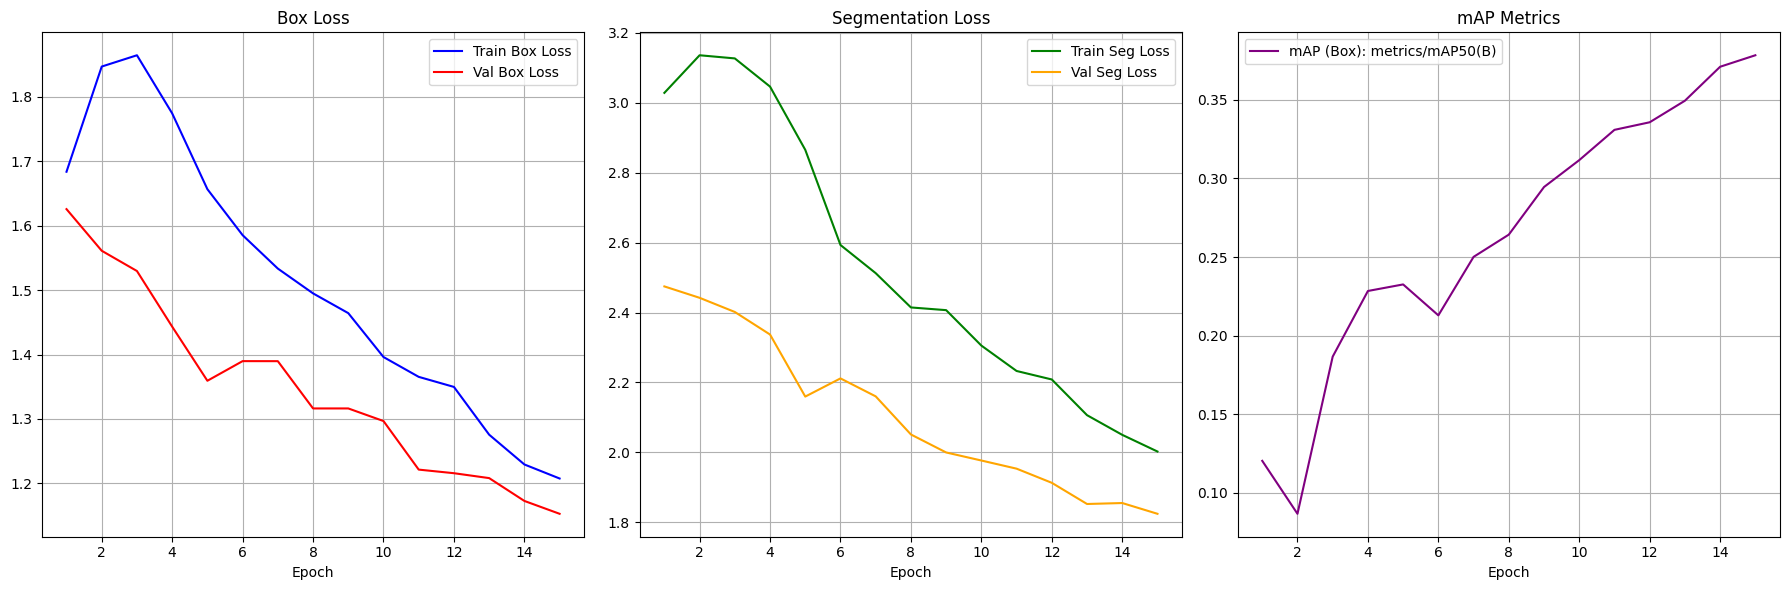


📋 Metrics Summary:
   • Box Loss: ✅
   • Segmentation Loss: ✅
   • mAP (Box): ✅
   • mAP (Mask): ❌
✅ Training metrics visualization completed



True

In [76]:
# Step 7: Visualize metrics
visualize_training_metrics()

In [73]:
# Step 8: Evaluate model
evaluate_segmentation_model(config_path)

🔍 Evaluating segmentation model...
Ultralytics 8.3.158 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-seg summary (fused): 113 layers, 2,834,763 parameters, 0 gradients, 10.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1019.1±418.6 MB/s, size: 24.4 KB)


val: Scanning /content/yolo11_trash/dataset/labels/val.cache... 1213 images, 637 backgrounds, 0 corrupt: 100%|██████████| 1213/1213 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:11<00:00,  6.49it/s]


                   all       1213        965      0.501      0.447      0.378      0.254      0.507      0.423      0.366      0.211
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/segment/val3
📊 Segmentation Model Evaluation Results:
   📦 Bounding Box Metrics:
      - mAP@0.5: 0.378
      - mAP@0.5:0.95: 0.254
      - Precision: 0.501
      - Recall: 0.447
   🎭 Mask Metrics:
      - mAP@0.5: 0.366
      - mAP@0.5:0.95: 0.211
      - Precision: 0.507
      - Recall: 0.423
✅ Model evaluation completed



{'bbox_map50': np.float64(0.3781647045961892),
 'bbox_map': np.float64(0.2536243298569569),
 'bbox_precision': np.float64(0.5009596080881107),
 'bbox_recall': np.float64(0.4466321243523316),
 'mask_map50': np.float64(0.36610765220121866),
 'mask_map': np.float64(0.2108454795616986),
 'mask_precision': np.float64(0.5071784578041975),
 'mask_recall': np.float64(0.4227979274611399)}

🎨 Visualizing segmentation predictions for 20+ images with original+ground_truth comparison...
✅ Model loaded successfully
📊 Visualizing 20 sample images with original+ground_truth vs prediction comparison
   - vid_000122_frame0000056.jpg: Found 1 predictions, 0 ground truth objects
   - vid_000131_frame0000005.jpg: No predictions found, 0 ground truth objects
   - vid_000298_frame0000001.jpg: Found 1 predictions, 1 ground truth objects
   - vid_000316_frame0000017.jpg: No predictions found, 0 ground truth objects
   - vid_000158_frame0000033.jpg: No predictions found, 0 ground truth objects
   - vid_000281_frame0000020.jpg: Found 1 predictions, 1 ground truth objects
   - vid_000119_frame0000012.jpg: Found 1 predictions, 1 ground truth objects
   - vid_000315_frame0000009.jpg: No predictions found, 0 ground truth objects
   - vid_000155_frame0000044.jpg: No predictions found, 1 ground truth objects
   - vid_000331_frame0000211.jpg: Found 1 predictions, 2 ground truth objects
   - vid_

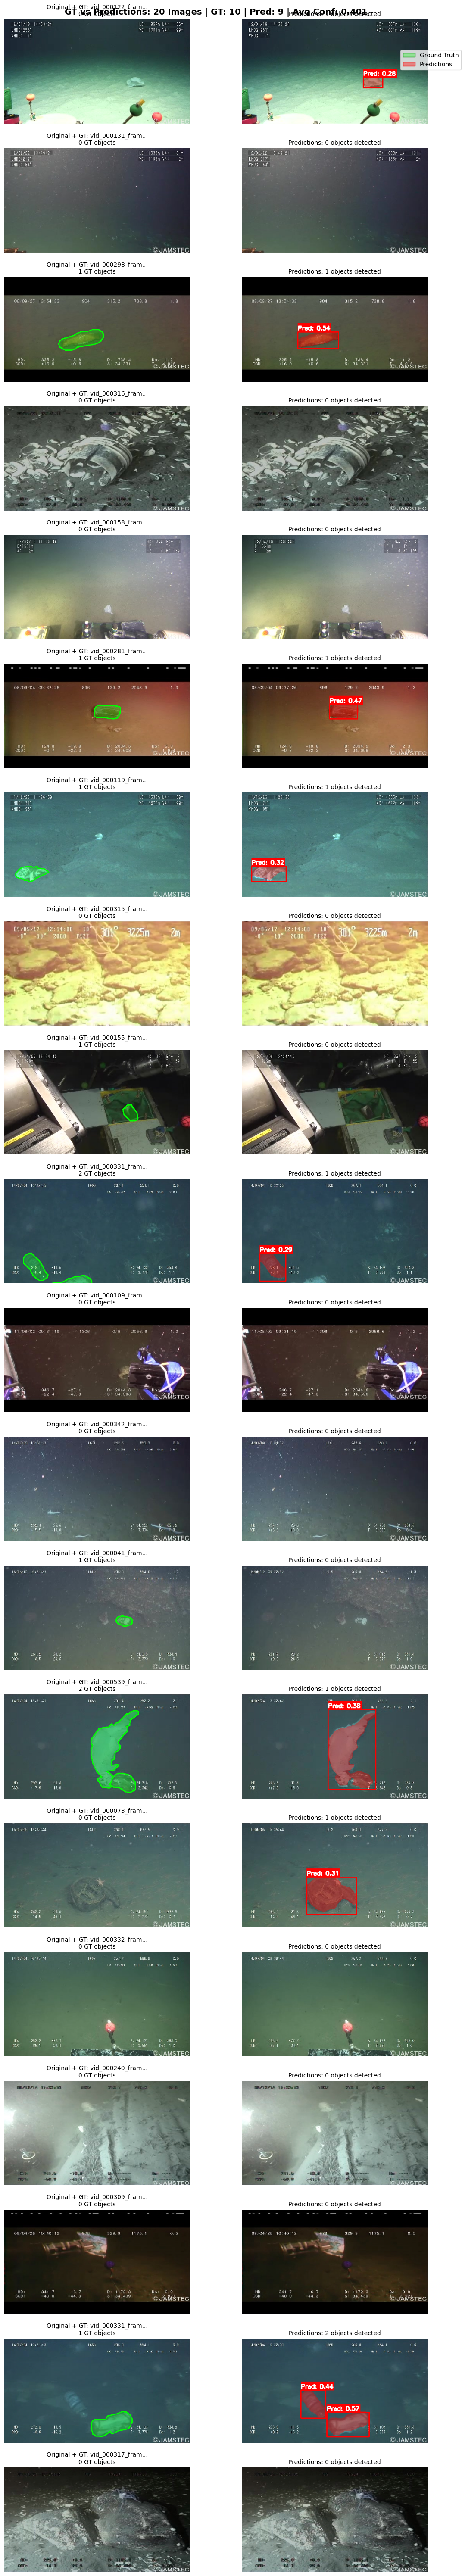


📊 VISUALIZATION STATISTICS:
   Total images processed: 20
   Ground Truth:
     - Total GT objects: 10
     - Images with GT: 8 (40.0%)
     - Average GT objects per image: 0.50
   Predictions:
     - Total objects detected: 9
     - Images with detections: 8 (40.0%)
     - Average objects per image: 0.45
     - Average confidence: 0.401
     - Confidence range: 0.279 - 0.570
     - Median confidence: 0.384
✅ Large-scale ground truth vs predictions visualization completed



True

In [74]:
# Step 9: Visualize predictions
visualize_segmentation_predictions()

In [80]:
# Step 10: Report final summary
final_report()

✅ Markdown summary saved at: yolo11_trash/results/final_summary.md


True

### ⚡ Option 2: Full Automatic Execution

Run the **entire end-to-end pipeline** with a single function:

```python
run_full_pipeline()
```

In [81]:
# ============================================================================
# MAIN FUNCTION TO RUN THE ENTIRE PIPELINE
# ============================================================================
def run_full_pipeline():
    """Run the entire training pipeline"""
    print("🚀 STARTING FULL YOLO11 PIPELINE - TRASH DETECTION AND SEGMENTATION")
    print("=" * 60)


    # Step 1: Initial setup
    initial_setup()

    # Step 2: Download dataset
    dataset_path = download_dataset()
    if not dataset_path:
        raise("Error: Could not download dataset")

    # Step 3: Analyze structure
    analyze_dataset_structure(dataset_path)

    # Step 4: Convert to YOLO format
    convert_to_yolo_format(dataset_path)

    # Step 5: Create YAML config
    config_path = create_yaml_config()

    # Step 6: Train model
    train_segmentation_model(config_path)

    # Step 7: Visualize metrics
    visualize_training_metrics()

    # Step 8: Evaluate model
    evaluate_segmentation_model(config_path)

    # Step 9: Visualize predictions
    visualize_segmentation_predictions()

    # Step 10: Report final summary
    final_report()

    print("\n🎉 PIPELINE SUCCESSFULLY COMPLETED!")
    print("=" * 60)

    return True

🚀 STARTING FULL YOLO11 PIPELINE - TRASH DETECTION AND SEGMENTATION
📁 Directories created in: yolo11_trash
✅ Initial setup completed for trash segmentation pipeline

📥 Downloading trashcan-segmentation-public dataset from Kaggle...
🔑 Setting up Kaggle credentials...
✅ Kaggle credentials configured
🔄 Downloading trashcan-segmentation-public...
📂 Extracting dataset...
✅ Dataset downloaded and extracted successfully
🔍 Analyzing Kaggle dataset structure...
📊 Dataset Structure Analysis:
   - Info: {'description': 'TrashCAN Segmentation Dataset', 'url': 'N/A', 'version': '0.5', 'year': 2020, 'contributor': 'IRVLab', 'date_created': '2020/6/24'}
   - Licenses: 1
   - Images: 6065
   - Annotations: 3350
   - Categories: 0
   - Class names: []
   - Annotations with segmentation: 3350
✅ Dataset structure analysis completed

🔄 Converting annotations to YOLO segmentation format...
yolo11_trash/raw_dataset/trashcan-segmentation-public/train/train
📂 Looking for images in: yolo11_trash/raw_dataset/tra

Converting images: 100%|██████████| 6065/6065 [00:02<00:00, 2151.40it/s]


📋 Conversion completed:
   - Images processed: 6065
   - Labels created: 6065
   - Single class segmentation (class 0)
📊 Splitting 6065 images into train/val...
📊 Dataset split completed:
   - Training images: 4852
   - Validation images: 1213
   - Images moved to val: 1213
   - Labels moved to val: 1213
✅ YOLO format conversion completed

📝 Creating YAML configuration for binary segmentation...
📊 Dataset verification:
   - Train images: 4852
   - Train labels: 4852
   - Val images: 1213
   - Val labels: 1213
📝 YAML configuration created: yolo11_trash/trash_segment_config.yaml
   - Path: /content/yolo11_trash/dataset
   - Classes: 1 - ['object']

🔍 Verifying label files...
   ✅ vid_000331_frame0000172.txt: class=0, coordinates=42
   ✅ vid_000278_frame0000016.txt: class=0, coordinates=36
   ⚠️ vid_000157_frame0000007.txt: Empty file
✅ Configuration completed

🚀 Starting YOLO11 segmentation model training...
✅ Model loaded successfully
🚀 Training mode: 15 epochs
🖥️ Using device: GPU
🎛️ T

train: Scanning /content/yolo11_trash/dataset/labels/train.cache... 4852 images, 2529 backgrounds, 0 corrupt: 100%|██████████| 4852/4852 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 346.0±91.1 MB/s, size: 26.7 KB)


val: Scanning /content/yolo11_trash/dataset/labels/val.cache... 1213 images, 637 backgrounds, 0 corrupt: 100%|██████████| 1213/1213 [00:00<?, ?it/s]


Plotting labels to yolo11_trash/trash_segmentation/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to yolo11_trash/trash_segmentation
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/15      1.15G      1.684      3.028      4.436      1.455          5        640: 100%|██████████| 1213/1213 [03:12<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:13<00:00, 10.97it/s]


                   all       1213        965      0.235      0.183       0.12     0.0633       0.25      0.175      0.117     0.0634

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/15      1.17G      1.847      3.136      3.257      1.582          6        640: 100%|██████████| 1213/1213 [03:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:13<00:00, 11.20it/s]


                   all       1213        965      0.204      0.176     0.0867      0.041      0.192      0.182      0.083     0.0374

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/15      1.18G      1.864      3.127      2.849      1.618          1        640: 100%|██████████| 1213/1213 [02:59<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:13<00:00, 11.35it/s]


                   all       1213        965      0.342      0.246      0.187      0.098       0.35       0.25      0.184     0.0929

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/15      1.18G      1.774      3.046      2.679      1.542          7        640: 100%|██████████| 1213/1213 [02:58<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:13<00:00, 11.38it/s]


                   all       1213        965      0.351       0.29      0.228      0.123      0.359      0.274      0.211       0.11

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/15      1.19G      1.656      2.865      2.478      1.473          6        640: 100%|██████████| 1213/1213 [02:58<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:13<00:00, 11.30it/s]

                   all       1213        965      0.356      0.333      0.233      0.131      0.349      0.311      0.216      0.112


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/15       1.2G      1.585      2.593      2.504      1.424          2        640: 100%|██████████| 1213/1213 [02:48<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:13<00:00, 11.50it/s]

                   all       1213        965      0.362      0.281      0.213      0.117      0.365      0.276        0.2      0.103



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/15      1.22G      1.533      2.513      2.361      1.392          3        640: 100%|██████████| 1213/1213 [02:48<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:13<00:00, 11.44it/s]

                   all       1213        965      0.399      0.305       0.25      0.146      0.392      0.298      0.238      0.131



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/15      1.22G      1.495      2.415      2.285      1.374          1        640: 100%|██████████| 1213/1213 [02:47<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:13<00:00, 11.45it/s]

                   all       1213        965      0.424      0.315      0.264      0.156      0.429      0.304      0.248      0.134



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/15      1.22G      1.464      2.407       2.21      1.346          5        640: 100%|██████████| 1213/1213 [02:48<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:13<00:00, 11.47it/s]


                   all       1213        965      0.431      0.343      0.295      0.178      0.432      0.334      0.284      0.156

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/15      1.22G      1.396      2.305      2.127      1.302          5        640: 100%|██████████| 1213/1213 [02:47<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:13<00:00, 11.58it/s]

                   all       1213        965      0.431      0.355      0.312      0.193      0.426      0.348      0.296      0.159



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/15      1.22G      1.365      2.233      2.045      1.283          5        640: 100%|██████████| 1213/1213 [02:47<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:13<00:00, 11.55it/s]

                   all       1213        965      0.509      0.348      0.331       0.21      0.499      0.339      0.319      0.173



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/15      1.22G       1.35      2.208      2.015      1.268          1        640: 100%|██████████| 1213/1213 [02:47<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:13<00:00, 11.51it/s]

                   all       1213        965      0.458      0.419      0.336      0.214      0.449       0.41      0.321      0.182



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/15      1.22G      1.276      2.106      1.925      1.216          3        640: 100%|██████████| 1213/1213 [02:47<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:13<00:00, 11.49it/s]

                   all       1213        965      0.496      0.399      0.349       0.23      0.492       0.39      0.336      0.192



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/15      1.22G      1.229       2.05      1.856      1.181          2        640: 100%|██████████| 1213/1213 [02:47<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:12<00:00, 11.86it/s]

                   all       1213        965      0.542      0.412      0.371      0.245      0.538      0.405       0.36      0.206



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/15      1.22G      1.208      2.002       1.78      1.174          4        640: 100%|██████████| 1213/1213 [02:47<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:12<00:00, 11.84it/s]

                   all       1213        965      0.502      0.447      0.378      0.253      0.508      0.424      0.367      0.211



15 epochs completed in 0.777 hours.
Optimizer stripped from yolo11_trash/trash_segmentation/weights/last.pt, 6.0MB
Optimizer stripped from yolo11_trash/trash_segmentation/weights/best.pt, 6.0MB

Validating yolo11_trash/trash_segmentation/weights/best.pt...
Ultralytics 8.3.158 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-seg summary (fused): 113 layers, 2,834,763 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 152/152 [00:10<00:00, 14.47it/s]


                   all       1213        965      0.501      0.447      0.378      0.253      0.508      0.424      0.367      0.211
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to yolo11_trash/trash_segmentation
✅ Segmentation model training completed

📈 Visualizing segmentation training metrics...
📊 Available columns: ['epoch', 'time', 'train/box_loss', 'train/seg_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'metrics/precision(M)', 'metrics/recall(M)', 'metrics/mAP50(M)', 'metrics/mAP50-95(M)', 'val/box_loss', 'val/seg_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']
📊 Data shape: (30, 21)
📊 Plot saved to: yolo11_trash/results/segmentation_training_metrics.png


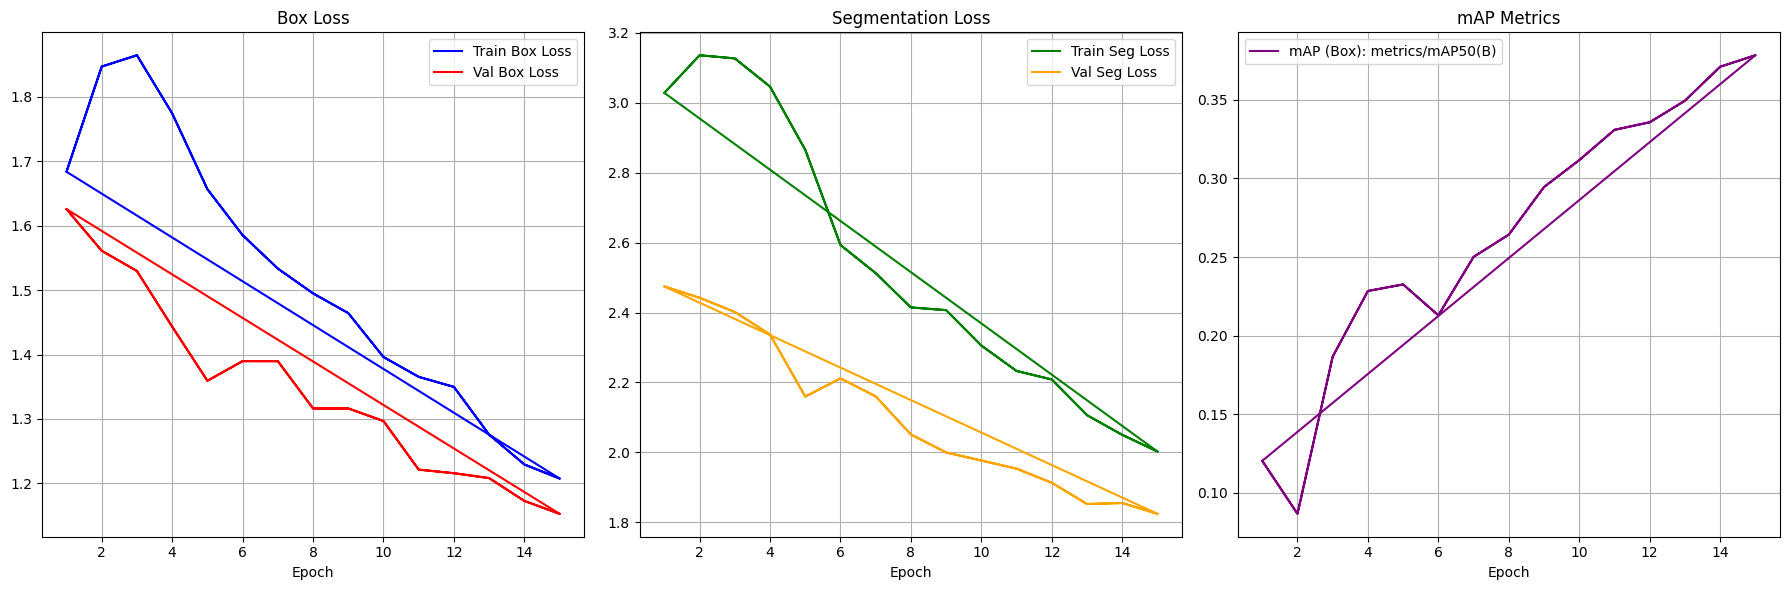


📋 Metrics Summary:
   • Box Loss: ✅
   • Segmentation Loss: ✅
   • mAP (Box): ✅
   • mAP (Mask): ❌
✅ Training metrics visualization completed

🔍 Evaluating segmentation model...
Ultralytics 8.3.158 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-seg summary (fused): 113 layers, 2,834,763 parameters, 0 gradients, 10.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 901.8±398.0 MB/s, size: 24.4 KB)


val: Scanning /content/yolo11_trash/dataset/labels/val.cache... 1213 images, 637 backgrounds, 0 corrupt: 100%|██████████| 1213/1213 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 76/76 [00:11<00:00,  6.59it/s]


                   all       1213        965      0.501      0.447      0.378      0.254      0.507      0.423      0.366      0.211
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/segment/val4
📊 Segmentation Model Evaluation Results:
   📦 Bounding Box Metrics:
      - mAP@0.5: 0.378
      - mAP@0.5:0.95: 0.254
      - Precision: 0.501
      - Recall: 0.447
   🎭 Mask Metrics:
      - mAP@0.5: 0.366
      - mAP@0.5:0.95: 0.211
      - Precision: 0.507
      - Recall: 0.423
✅ Model evaluation completed

🎨 Visualizing segmentation predictions for 20+ images with original+ground_truth comparison...
✅ Model loaded successfully
📊 Visualizing 20 sample images with original+ground_truth vs prediction comparison
   - vid_000122_frame0000056.jpg: Found 1 predictions, 0 ground truth objects
   - vid_000131_frame0000005.jpg: No predictions found, 0 ground truth objects
   - vid_000298_frame0000001.jpg: Found 1 predictions, 1 ground truth obje

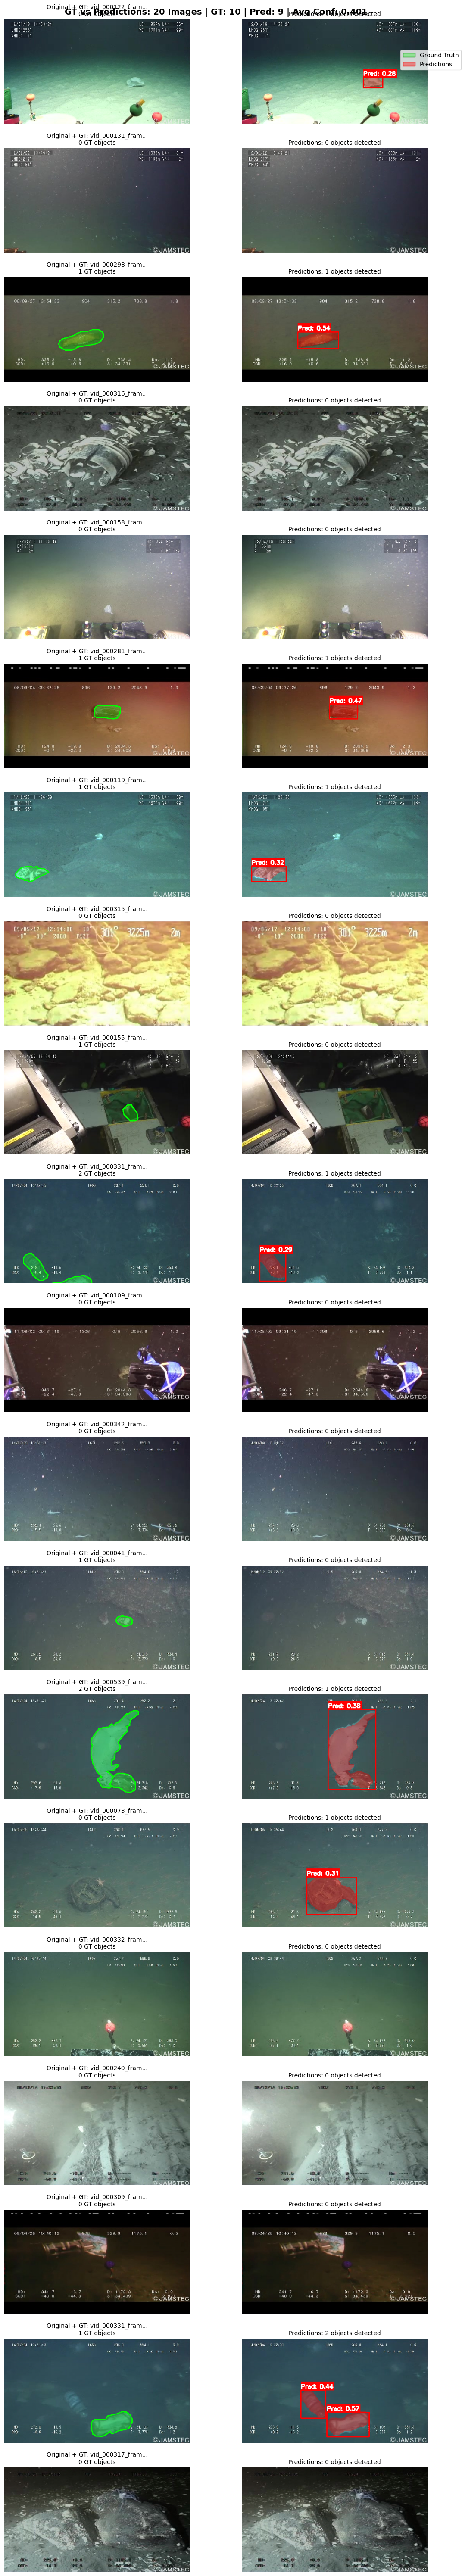


📊 VISUALIZATION STATISTICS:
   Total images processed: 20
   Ground Truth:
     - Total GT objects: 10
     - Images with GT: 8 (40.0%)
     - Average GT objects per image: 0.50
   Predictions:
     - Total objects detected: 9
     - Images with detections: 8 (40.0%)
     - Average objects per image: 0.45
     - Average confidence: 0.401
     - Confidence range: 0.279 - 0.570
     - Median confidence: 0.384
✅ Large-scale ground truth vs predictions visualization completed

✅ Markdown summary saved at: yolo11_trash/results/final_summary.md

🎉 PIPELINE SUCCESSFULLY COMPLETED!


True

In [82]:
run_full_pipeline()

Perfecto, con base en la estructura real que muestras en la imagen, aquí tienes una versión precisa y profesional del bloque `🏗️ Project Structure`, adaptado para tu proyecto de detección y segmentación de basura con YOLO11:

---

## 🏗️ Project Structure

After running the full YOLO11 segmentation pipeline, your project directory will be organized as follows:

```
yolo11_trash/
├── dataset/
│   ├── images/
│   │   ├── train/                      # Training images
│   │   └── val/                        # Validation images
│   └── labels/
│       ├── train/                      # YOLO polygonal labels (segmentation masks)
│       ├── val/
│       ├── train.cache                 # YOLO cache files
│       └── val.cache
├── raw_dataset/
│   └── trashcan-segmentation/         # Original dataset (raw format)
│       ├── train/                     # Raw training samples
│       ├── test/                      # Raw test samples
│       ├── sample_submission.csv
│       ├── test-without-segmentation/
│       └── train.json                 # Original COCO-style annotations
├── results/
│   ├── evaluation_results.json        # Final mAP, IoU, F1, etc.
│   ├── final_summary.md               # Textual summary of the experiment
│   ├── segmentation_comparison.png    # Side-by-side ground truth vs predictions
│   ├── segmentation_grid.png          # Grid visualization of predictions
│   ├── segmentation_gt_vs_pred.png    # Ground truth overlay
│   ├── segmentation_predictions.png   # Raw predicted masks
│   ├── segmentation_training_metrics.png
├── trash_segmentation/
│   ├── weights/
│   │   ├── best.pt                    # Best YOLO11 model checkpoint
│   │   └── last.pt                    # Final epoch model
│   ├── MaskF1_curve.png               # F1-score evolution during training
│   ├── MaskPR_curve.png               # Precision-Recall curve (mask level)
│   ├── MaskP_curve.png                # Precision curve
│   ├── MaskR_curve.png                # Recall curve
│   ├── args.yaml                      # Training arguments
│   ├── confusion_matrix.png           # Visual confusion matrix
│   ├── confusion_matrix_normalized.png
│   ├── labels.jpg                     # Label distribution plot
│   ├── labels_correlogram.png         # Label co-occurrence
│   ├── results.csv                    # Epoch-by-epoch training metrics
│   ├── train_batch*.jpg               # Debug samples (batches)
│   ├── val_batch*_labels.jpg
│   ├── val_batch*_pred.jpg
├── trash_segment_config.yaml          # YOLO dataset config file
└── .ipynb_checkpoints/                # Notebook auto-saves
```


